In [1]:
import numpy as np
import pandas as pd
import operator
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn.preprocessing import StandardScaler

In [2]:
# read data
data = pd.read_csv('dataset2_addfeatures.csv')
# sale price
SalePrice = data['SalePrice'].dropna()
cols_categoric = data.select_dtypes(include = ["object"]).columns
cols_numeric = set(data.drop(['SalePrice','Id'],axis=1).columns.tolist())-set(cols_categoric)
# number of training samples
n_train = SalePrice.shape[0]
# add total square footage
data.head()

,SalePrice,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,...,EnclosedPorch_log,ScreenPorch_log,LotFrontage_log,12_rooms_plus_dummy,2_kitchens_plus_dummy,5_bedroom_plus_dummy,1_bedroom_less_dummy,4_garage_more_dummy,compPrice,compIndex
0,208500.0,856,854,0,3,706.0,0.0,1.0,0.0,150.0,...,0.000000,0.0,4.189655,0,0,0,0,0,202980.0,37.2
1,181500.0,1262,0,0,3,978.0,0.0,0.0,1.0,284.0,...,0.000000,0.0,4.394449,0,0,0,0,0,206791.8,32.4
2,223500.0,920,866,0,3,486.0,0.0,1.0,0.0,434.0,...,0.000000,0.0,4.234107,0,0,0,0,0,180480.0,37.2
3,140000.0,961,756,0,3,216.0,0.0,1.0,0.0,540.0,...,5.609472,0.0,4.110874,0,0,0,0,0,189220.0,31.0
4,250000.0,1145,1053,0,4,655.0,0.0,1.0,0.0,490.0,...,0.000000,0.0,4.442651,0,0,0,0,0,206150.0,36.4


**define lasso model**

In [3]:
# repeated k-fold cv
repeatedkfold = RepeatedKFold()
rkf = RepeatedKFold(n_splits=10, n_repeats=1, random_state=2652124)
# lasso model
lassocv = LassoCV(cv=rkf,n_alphas=1000,n_jobs=-1)

**validation error with 10-fold cross-validation**

In [4]:
def model_validation_score(X,y,model=None,n_split=10,n_repeats=1,msg=False):
    if model == None: model = LassoCV(cv=10,n_jobs=-1)
    repeatedkfold = RepeatedKFold()
    rkf = RepeatedKFold(n_splits=n_split, n_repeats=n_repeats, random_state=2652124)
    sample = range(0,X.shape[0])
    train_score = []
    test_score = []
    y_train_lst = []
    y_train_estimated_lst = []
    y_test_lst = []
    y_test_estimated_lst = []
    iteration = 1
    for train_index, test_index in rkf.split(sample):
        if (msg==True): print('iteration {}'.format(iteration))
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        reg = model.fit(X_train,y_train)                
        y_train_lst += y_train.tolist()
        y_test_lst += y_test.tolist()
        y_train_estimated_lst += model.predict(X_train).tolist()
        y_test_estimated_lst += model.predict(X_test).tolist()
        iteration += 1
    train_score = np.sqrt(mean_squared_error(y_train_lst,y_train_estimated_lst))
    test_score = np.sqrt(mean_squared_error(y_test_lst,y_test_estimated_lst))
    if (msg==True):
        print('train root_mean_squared_log_error: {}'.format(train_score))
        print('test root_mean_squared_log_error: {}'.format(test_score))
    return(train_score,test_score)

**agglomerative clustering algorithm**

In [5]:
def scaling(df): return(((df.T - df.T.mean())/df.T.std()).T)  
    
def prepare_clustering_data(data,n_train,SalePrice,col):
    # training set
    X = data[:n_train]
    # calculate SalePrice per square foot
    PPSqf = SalePrice/X['TotalSF']
    # encode categoric variables
    dummies = pd.get_dummies(X[col])
    # create dictionary of SalePrice by neighbourhood
    dict_logSalePrice = {}
    dict_PPSqf = {}
    for key in dummies.columns.tolist():
        mask = dummies[key].eq(1)
        dict_logSalePrice[key] = np.array(np.log1p(SalePrice[mask]).values)
        dict_PPSqf[key] = np.array(PPSqf[mask].values)
        # price per square foot: mean, median, min, max, 25th, 75th percentiles 
        dict_PPSqf = {k: [np.percentile(v, 5),np.percentile(v, 25),np.mean(v),np.median(v),\
                          np.percentile(v, 75),np.percentile(v, 95)] for k, v in dict_PPSqf.items()}
        # log sales price: mean, median, min, max, 25th, 75th percentiles 
        dict_logSalePrice = {k: [np.percentile(v, 5),np.percentile(v, 25),np.mean(v),np.median(v),\
                          np.percentile(v, 75),np.percentile(v, 95)] for k, v in dict_logSalePrice.items()}
        df = pd.concat([pd.DataFrame(dict_PPSqf),pd.DataFrame(dict_logSalePrice)],ignore_index=True)
    return(df)
    
def plot_dendrogram(df,col):
    # plot dendrogram    
    plt.figure(figsize=(10, 5))
    plt.title(col)
    labels_lst = list(map(lambda x: x.replace(col+'_',''),df.columns.tolist()))
    dend = shc.dendrogram(shc.linkage(scaling(df).T, method='ward'),labels=labels_lst,orientation='right')  
    plt.show()
    
def clusters(data,n_train,SalePrice,col,n_clusters,scatter_plot=False):
    # encode categoric variables
    dummies = pd.get_dummies(data[col])
    # training samples
    X = data[:n_train]
    # prepare clustering data
    df = prepare_clustering_data(data,n_train,SalePrice,col)
    # save columns of df
    cols = df.columns.tolist()
    # create clustering object
    clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(scaling(df).T)   
    labels = clustering.labels_
    if scatter_plot == True:
        fig = plt.figure(figsize=(10,5))
        plt.scatter(df.iloc[2], df.iloc[8], marker='o', c = labels, cmap='rainbow')
        for i in range(len(cols)):
            plt.text(df.iloc[2].tolist()[i]+.03, df.iloc[8].tolist()[i]+.03, cols[i], fontsize=8)
        plt.xlabel("mean price per sqft ($)")
        plt.ylabel("mean log price ($)")
        plt.grid(True)
        plt.title(col+': number of clusters = {}'.format(n_clusters))
        plt.show()
    # find columns for label k
    find_cols = lambda k: [cols[i] for i in np.where(labels==k)[0].tolist()]
    dict_dummies = {}
    for k in range(n_clusters):
        key = '_'.join(find_cols(k))
        value = dummies.loc[:,find_cols(k)].sum(axis=1).values
        dict_dummies[key] = value 
    dummies_merged = pd.DataFrame(dict_dummies)
    merged = pd.DataFrame({col:dummies_merged.columns[np.where(dummies_merged!=0)[1]]})
    return(merged)

def find_n_clusters(data,n_train,SalePrice,col,max_clusters=None):
    # cols categoric
    cols_categoric = data.select_dtypes(include = ["object"]).columns
    # numeric columns
    cols_numeric = list(set(data.columns.tolist())-set(cols_categoric))
    # categoric columns excluding column col
    cols_categoric_ex_col = list(set(cols_categoric)-set([col]))
    # train data
    X = data[:n_train]
    X_ex_col = pd.concat([X.loc[:,cols_numeric], pd.get_dummies(X.loc[:,cols_categoric_ex_col])], axis=1)
    # number of values of categoric variable col
    if max_clusters==None: max_clusters = pd.get_dummies(X[col]).shape[1]
    # testing error including single variable
    training_error_lst = []
    testing_error_lst = []
    # testing error including intereaction term
    training_error_all_lst = []
    testing_error_all_lst = []    
    # loop over categoric values of col
    for i in range(2,max_clusters+1):
        print('Iteration: {} out of {}'.format(i,max_clusters))
        dummies_merged = pd.get_dummies(clusters(data,n_train,SalePrice,col,i))[:n_train]
        # repeated k-fold
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            training_error,testing_error = model_validation_score(dummies_merged,np.log1p(SalePrice),n_repeats=1)
            
            #reg = lassocv.fit(dummies_merged,np.log1p(SalePrice))            
            #testing_error_best_alpha = np.sqrt(mean_squared_error(reg.predict(dummies_merged),np.log1p(SalePrice)))
            
            dataT = pd.concat([X_ex_col,dummies_merged],axis=1)
            dataT = (dataT - dataT.mean())/dataT.std()
            
            #reg = lassocv.fit(dataT,np.log1p(SalePrice))            
            #testing_error_all = np.sqrt(mean_squared_error(reg.predict(dataT),np.log1p(SalePrice)))
            
            training_error_all,testing_error_all = \
                    model_validation_score(dataT,np.log1p(SalePrice),n_repeats=10)
        
        training_error_lst.append(training_error)
        testing_error_lst.append(testing_error)      
        training_error_all_lst.append(training_error_all)          
        testing_error_all_lst.append(testing_error_all)          
    # plot testing errors
    f = plt.figure(figsize=(10,5))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    x = np.linspace(2,max_clusters,max_clusters-1)
    ax.plot(x, training_error_lst,marker='o',color='blue',label='training error')
    ax.plot(x, testing_error_lst,marker='o',color='red',label='testing error')    
    ax.set_title(col+": single variable")
    ax.set_xlabel("number of clusters")
    ax.set_ylabel("sqrt_mean_squared_log_error")
    ax.legend()
    ax.grid(True)
    ax2.plot(x, training_error_all_lst,marker='o',color='blue',label='training error')
    ax2.plot(x, testing_error_all_lst,marker='o',color='red',label='testing error')
    ax2.set_title(col+": with interaction")
    ax2.set_xlabel("number of clusters")
    ax2.set_ylabel("sqrt_mean_squared_log_error")
    ax2.legend()
    ax2.grid(True)
    f.show()

**categoric columns in descending order (number categories)**

In [6]:
def categoric_cols_descending(data,col_categoric):    
    d = {col:len(pd.get_dummies(data[col]).columns.tolist()) for col in cols_categoric}
    d = sorted(d.items(),key=operator.itemgetter(1),reverse=True)
    return(d)
# sort categoric features
cols_desc = categoric_cols_descending(data,cols_categoric)
cols_desc

[('Neighborhood', 25),
 ('Exterior2nd', 16),
 ('MSSubClass', 16),
 ('Exterior1st', 15),
 ('MoSold', 12),
 ('Condition1', 9),
 ('SaleType', 9),
 ('Condition2', 8),
 ('HouseStyle', 8),
 ('BsmtFinType1', 7),
 ('BsmtFinType2', 7),
 ('Functional', 7),
 ('GarageType', 7),
 ('RoofMatl', 7),
 ('FireplaceQu', 6),
 ('Foundation', 6),
 ('GarageCond', 6),
 ('GarageQual', 6),
 ('Heating', 6),
 ('RoofStyle', 6),
 ('SaleCondition', 6),
 ('BldgType', 5),
 ('BsmtCond', 5),
 ('BsmtQual', 5),
 ('Electrical', 5),
 ('ExterCond', 5),
 ('Fence', 5),
 ('HeatingQC', 5),
 ('LotConfig', 5),
 ('MSZoning', 5),
 ('MiscFeature', 5),
 ('BsmtExposure', 4),
 ('ExterQual', 4),
 ('GarageFinish', 4),
 ('KitchenQual', 4),
 ('LandContour', 4),
 ('LotShape', 4),
 ('MasVnrType', 4),
 ('PoolQC', 4),
 ('Alley', 3),
 ('LandSlope', 3),
 ('PavedDrive', 3),
 ('CentralAir', 2),
 ('Street', 2),
 ('Utilities', 2)]

**create data32 file as copy of data**

In [7]:
data32 = data.copy()

**determine optimal number of clusters**

Iteration: 2 out of 25
Iteration: 3 out of 25
Iteration: 4 out of 25
Iteration: 5 out of 25
Iteration: 6 out of 25
Iteration: 7 out of 25
Iteration: 8 out of 25
Iteration: 9 out of 25
Iteration: 10 out of 25
Iteration: 11 out of 25
Iteration: 12 out of 25
Iteration: 13 out of 25
Iteration: 14 out of 25
Iteration: 15 out of 25
Iteration: 16 out of 25
Iteration: 17 out of 25
Iteration: 18 out of 25
Iteration: 19 out of 25
Iteration: 20 out of 25
Iteration: 21 out of 25
Iteration: 22 out of 25
Iteration: 23 out of 25
Iteration: 24 out of 25
Iteration: 25 out of 25


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


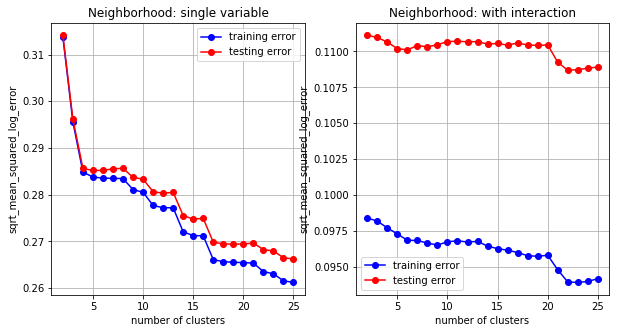

Iteration: 2 out of 16
Iteration: 3 out of 16
Iteration: 4 out of 16
Iteration: 5 out of 16
Iteration: 6 out of 16
Iteration: 7 out of 16
Iteration: 8 out of 16
Iteration: 9 out of 16
Iteration: 10 out of 16
Iteration: 11 out of 16
Iteration: 12 out of 16
Iteration: 13 out of 16
Iteration: 14 out of 16
Iteration: 15 out of 16
Iteration: 16 out of 16


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


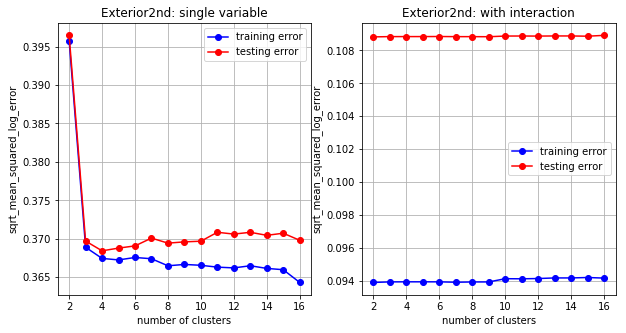

Iteration: 2 out of 15
Iteration: 3 out of 15
Iteration: 4 out of 15
Iteration: 5 out of 15
Iteration: 6 out of 15
Iteration: 7 out of 15
Iteration: 8 out of 15
Iteration: 9 out of 15
Iteration: 10 out of 15
Iteration: 11 out of 15
Iteration: 12 out of 15
Iteration: 13 out of 15
Iteration: 14 out of 15
Iteration: 15 out of 15


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


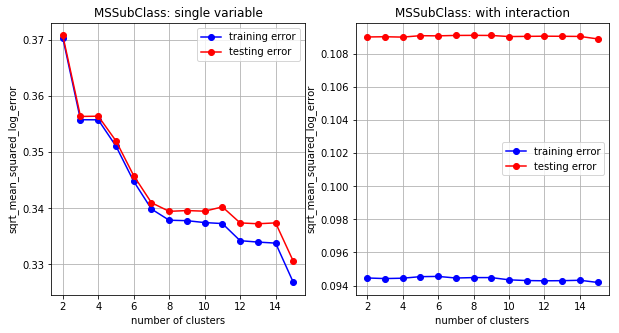

Iteration: 2 out of 15
Iteration: 3 out of 15
Iteration: 4 out of 15
Iteration: 5 out of 15
Iteration: 6 out of 15
Iteration: 7 out of 15
Iteration: 8 out of 15
Iteration: 9 out of 15
Iteration: 10 out of 15
Iteration: 11 out of 15
Iteration: 12 out of 15
Iteration: 13 out of 15
Iteration: 14 out of 15
Iteration: 15 out of 15


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


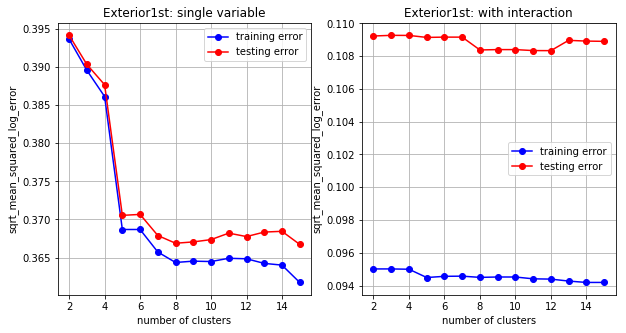

Iteration: 2 out of 12
Iteration: 3 out of 12
Iteration: 4 out of 12
Iteration: 5 out of 12
Iteration: 6 out of 12
Iteration: 7 out of 12
Iteration: 8 out of 12
Iteration: 9 out of 12
Iteration: 10 out of 12
Iteration: 11 out of 12
Iteration: 12 out of 12


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


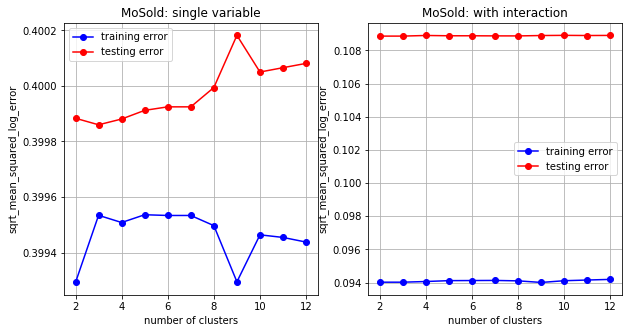

Iteration: 2 out of 9
Iteration: 3 out of 9
Iteration: 4 out of 9
Iteration: 5 out of 9
Iteration: 6 out of 9
Iteration: 7 out of 9
Iteration: 8 out of 9
Iteration: 9 out of 9


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


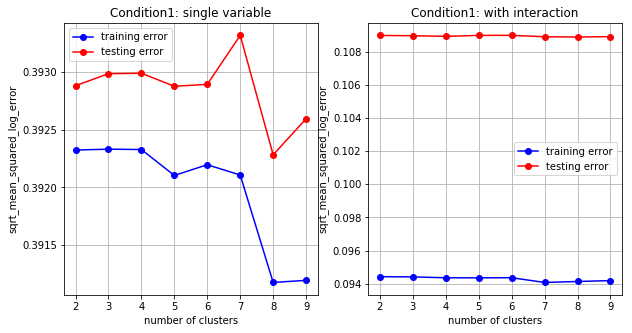

Iteration: 2 out of 9
Iteration: 3 out of 9
Iteration: 4 out of 9
Iteration: 5 out of 9
Iteration: 6 out of 9
Iteration: 7 out of 9
Iteration: 8 out of 9
Iteration: 9 out of 9


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


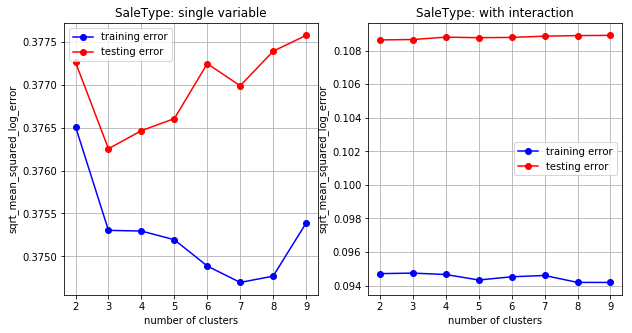

Iteration: 2 out of 8
Iteration: 3 out of 8
Iteration: 4 out of 8
Iteration: 5 out of 8
Iteration: 6 out of 8
Iteration: 7 out of 8
Iteration: 8 out of 8


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


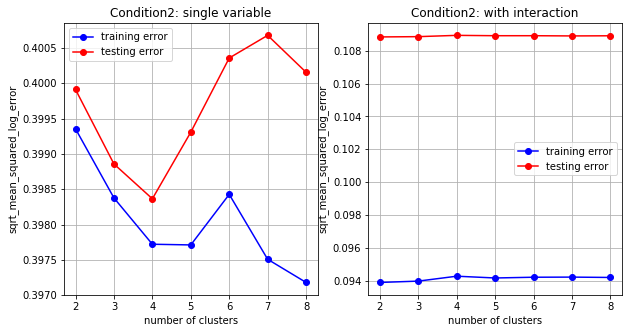

Iteration: 2 out of 8
Iteration: 3 out of 8
Iteration: 4 out of 8
Iteration: 5 out of 8
Iteration: 6 out of 8
Iteration: 7 out of 8
Iteration: 8 out of 8


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


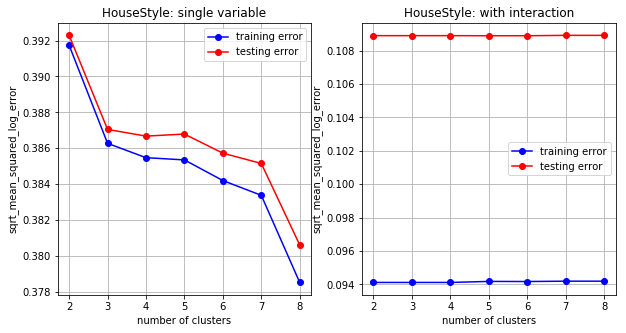

Iteration: 2 out of 7
Iteration: 3 out of 7
Iteration: 4 out of 7
Iteration: 5 out of 7
Iteration: 6 out of 7
Iteration: 7 out of 7


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


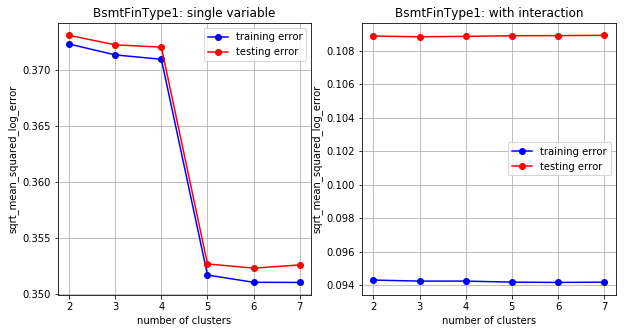

Iteration: 2 out of 7
Iteration: 3 out of 7
Iteration: 4 out of 7
Iteration: 5 out of 7
Iteration: 6 out of 7
Iteration: 7 out of 7


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


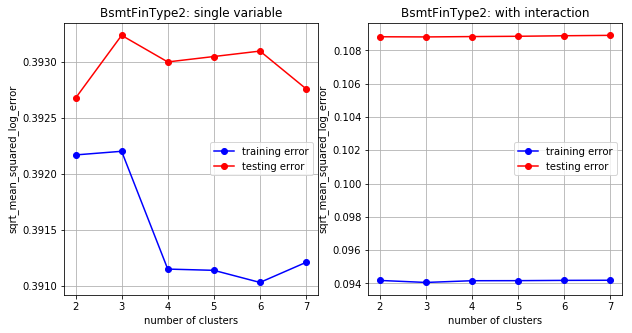

Iteration: 2 out of 7
Iteration: 3 out of 7
Iteration: 4 out of 7
Iteration: 5 out of 7
Iteration: 6 out of 7
Iteration: 7 out of 7


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


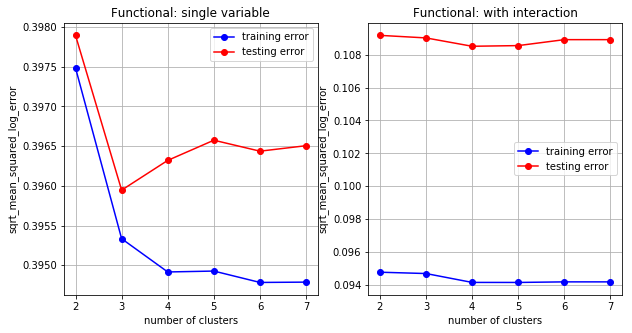

Iteration: 2 out of 7
Iteration: 3 out of 7
Iteration: 4 out of 7
Iteration: 5 out of 7
Iteration: 6 out of 7
Iteration: 7 out of 7


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


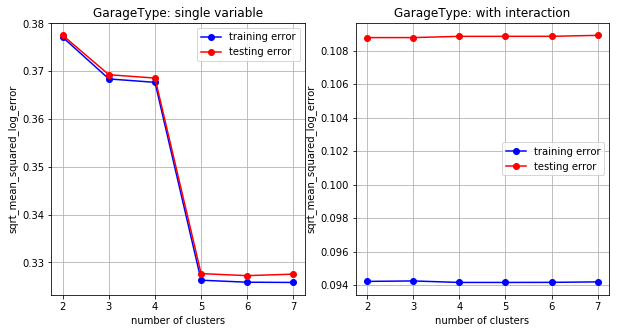

Iteration: 2 out of 7
Iteration: 3 out of 7
Iteration: 4 out of 7
Iteration: 5 out of 7
Iteration: 6 out of 7
Iteration: 7 out of 7


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


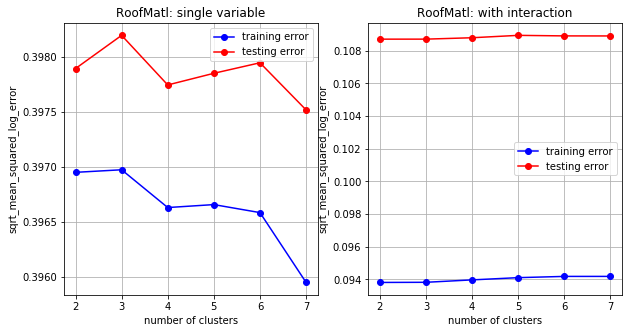

Iteration: 2 out of 6
Iteration: 3 out of 6
Iteration: 4 out of 6
Iteration: 5 out of 6
Iteration: 6 out of 6


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


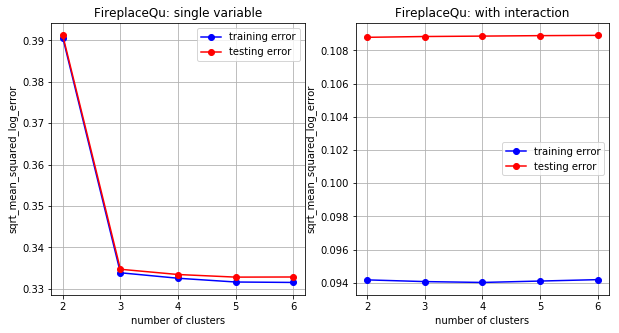

Iteration: 2 out of 6
Iteration: 3 out of 6
Iteration: 4 out of 6
Iteration: 5 out of 6
Iteration: 6 out of 6


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


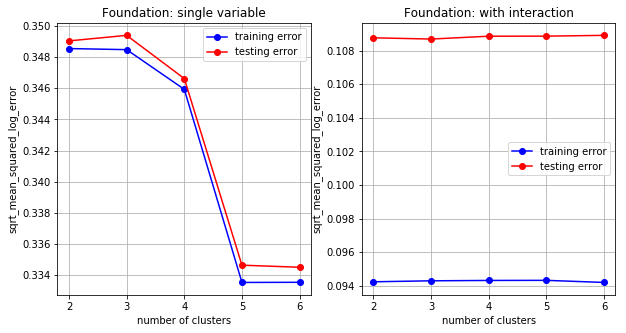

Iteration: 2 out of 6
Iteration: 3 out of 6
Iteration: 4 out of 6
Iteration: 5 out of 6
Iteration: 6 out of 6


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


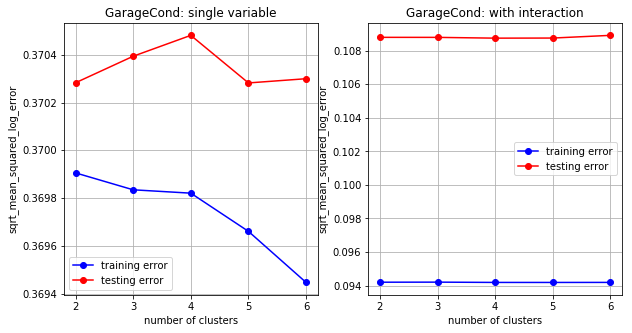

Iteration: 2 out of 6
Iteration: 3 out of 6
Iteration: 4 out of 6
Iteration: 5 out of 6
Iteration: 6 out of 6


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


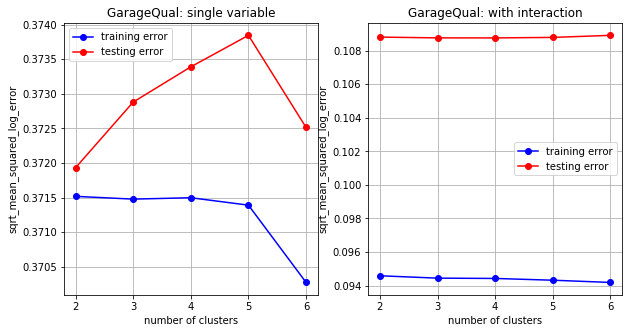

Iteration: 2 out of 6
Iteration: 3 out of 6
Iteration: 4 out of 6
Iteration: 5 out of 6
Iteration: 6 out of 6


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


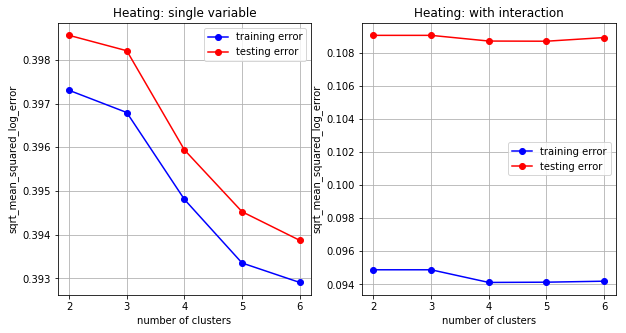

Iteration: 2 out of 6
Iteration: 3 out of 6
Iteration: 4 out of 6
Iteration: 5 out of 6
Iteration: 6 out of 6


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


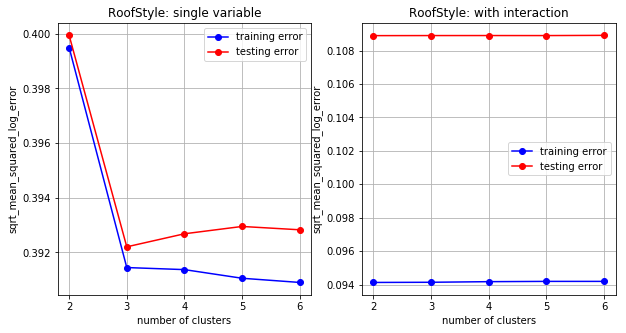

Iteration: 2 out of 6
Iteration: 3 out of 6
Iteration: 4 out of 6
Iteration: 5 out of 6
Iteration: 6 out of 6


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


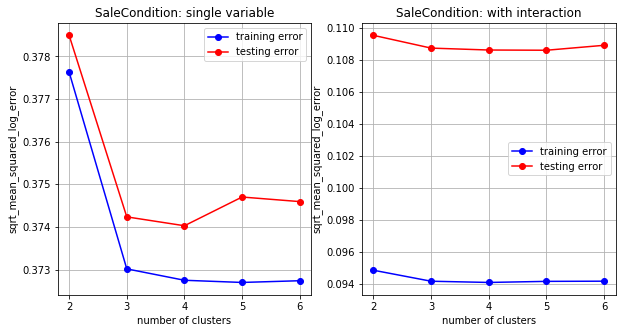

Iteration: 2 out of 5
Iteration: 3 out of 5
Iteration: 4 out of 5
Iteration: 5 out of 5


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


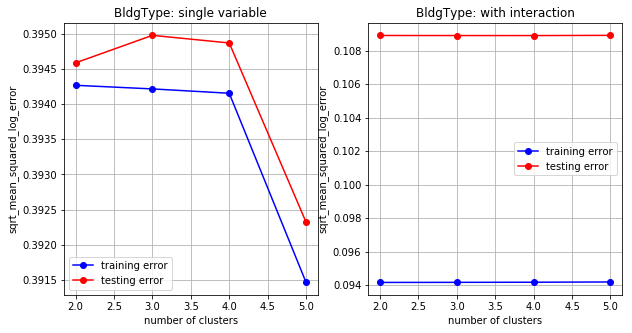

Iteration: 2 out of 5
Iteration: 3 out of 5
Iteration: 4 out of 5
Iteration: 5 out of 5


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


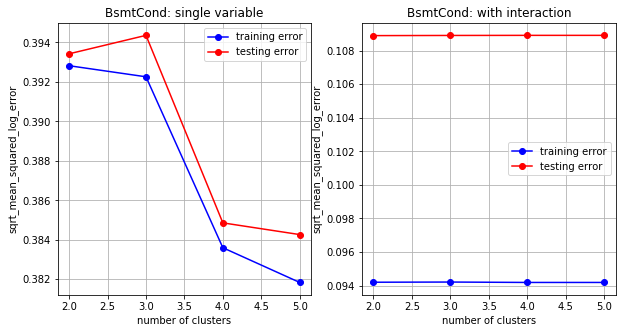

Iteration: 2 out of 5
Iteration: 3 out of 5
Iteration: 4 out of 5
Iteration: 5 out of 5


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


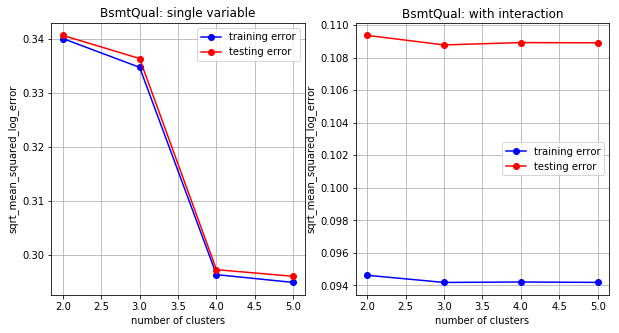

Iteration: 2 out of 5
Iteration: 3 out of 5
Iteration: 4 out of 5
Iteration: 5 out of 5


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


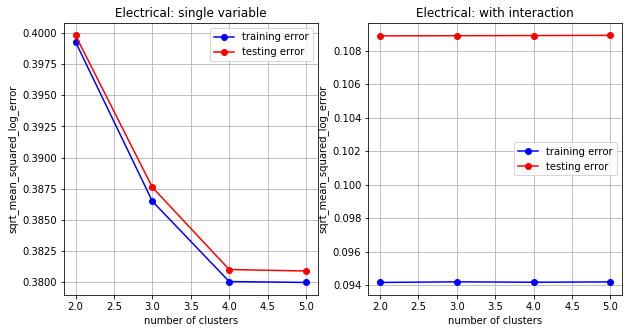

Iteration: 2 out of 5
Iteration: 3 out of 5
Iteration: 4 out of 5
Iteration: 5 out of 5


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


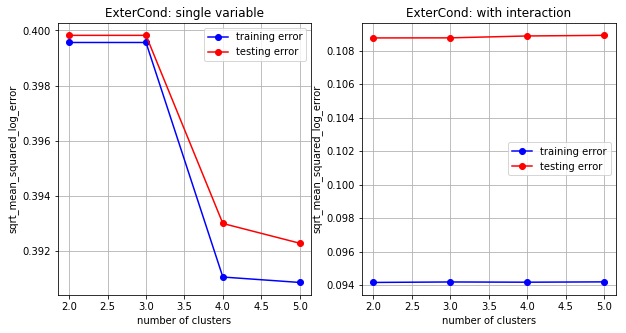

Iteration: 2 out of 5
Iteration: 3 out of 5
Iteration: 4 out of 5
Iteration: 5 out of 5


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


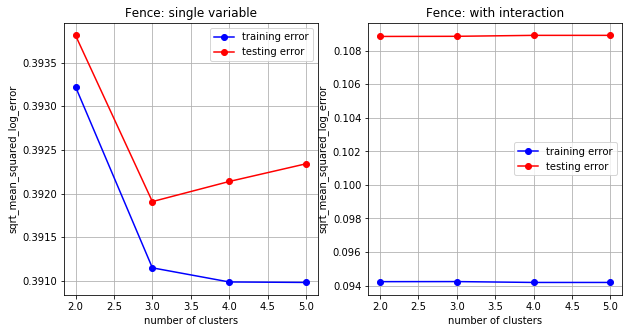

Iteration: 2 out of 5
Iteration: 3 out of 5
Iteration: 4 out of 5
Iteration: 5 out of 5


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


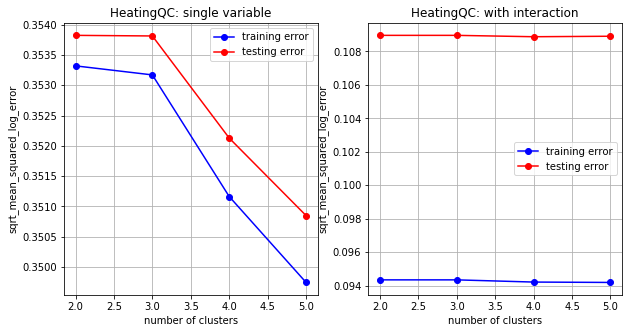

Iteration: 2 out of 5
Iteration: 3 out of 5
Iteration: 4 out of 5
Iteration: 5 out of 5


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


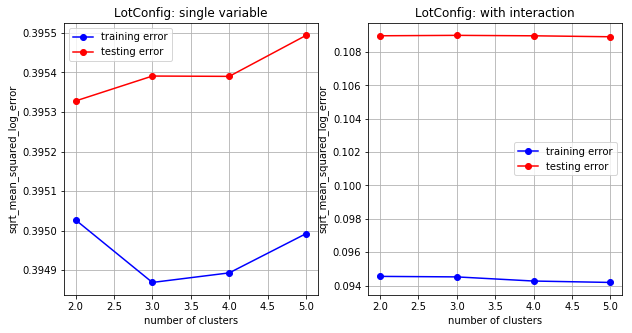

Iteration: 2 out of 5
Iteration: 3 out of 5
Iteration: 4 out of 5
Iteration: 5 out of 5


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


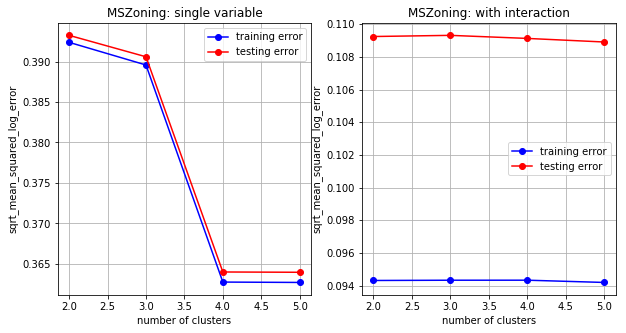

Iteration: 2 out of 5
Iteration: 3 out of 5
Iteration: 4 out of 5
Iteration: 5 out of 5


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


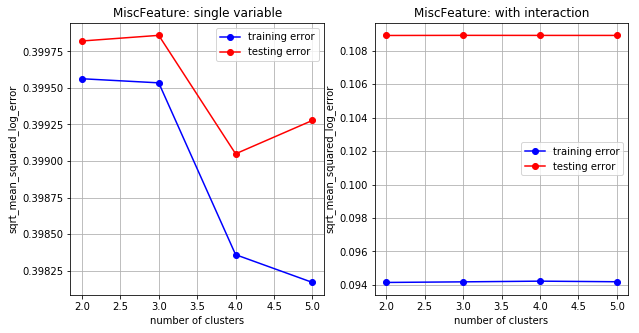

Iteration: 2 out of 4
Iteration: 3 out of 4
Iteration: 4 out of 4


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


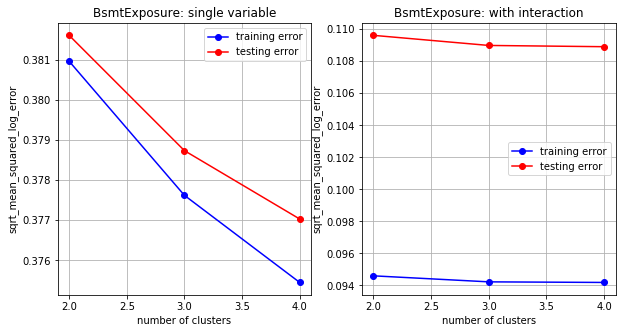

Iteration: 2 out of 4
Iteration: 3 out of 4
Iteration: 4 out of 4


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


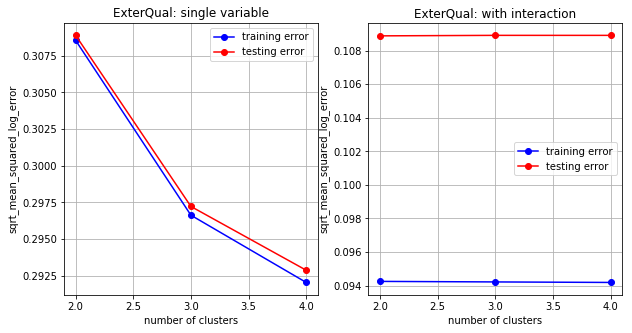

Iteration: 2 out of 4
Iteration: 3 out of 4
Iteration: 4 out of 4


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


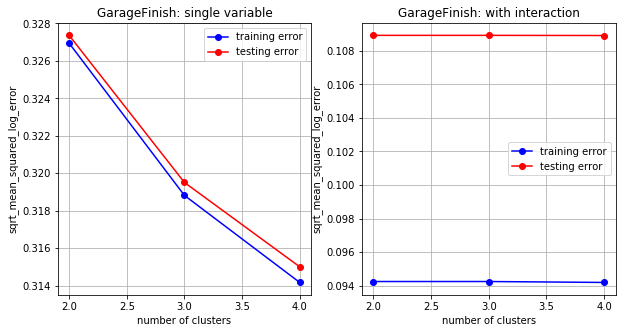

Iteration: 2 out of 4
Iteration: 3 out of 4
Iteration: 4 out of 4


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


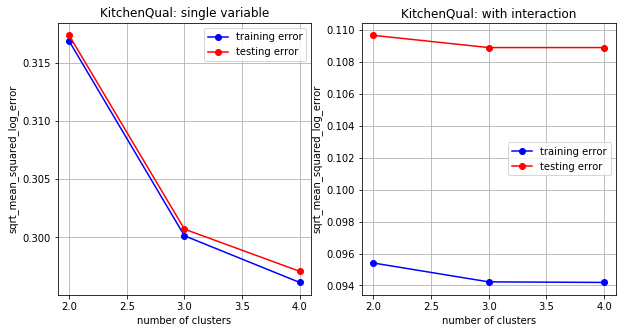

Iteration: 2 out of 4
Iteration: 3 out of 4
Iteration: 4 out of 4


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


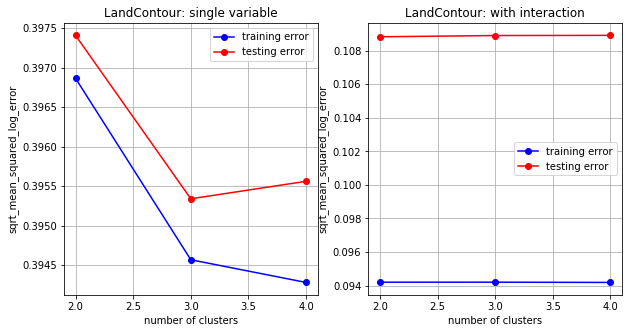

Iteration: 2 out of 4
Iteration: 3 out of 4
Iteration: 4 out of 4


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


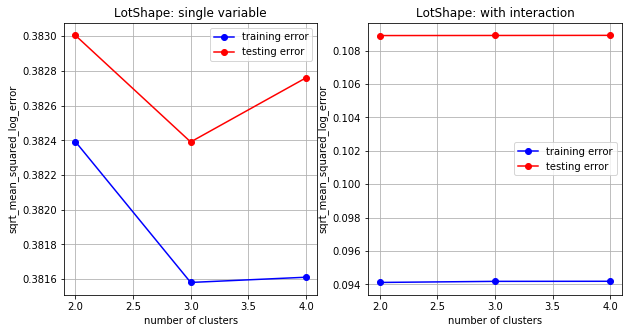

Iteration: 2 out of 4
Iteration: 3 out of 4
Iteration: 4 out of 4


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


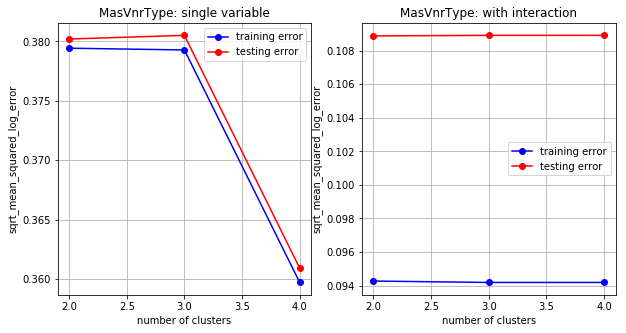

Iteration: 2 out of 4
Iteration: 3 out of 4
Iteration: 4 out of 4


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


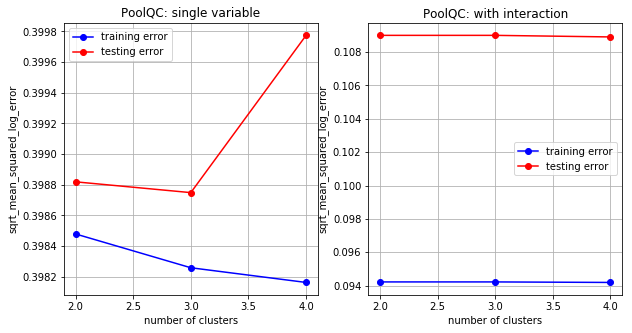

Iteration: 2 out of 3
Iteration: 3 out of 3


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


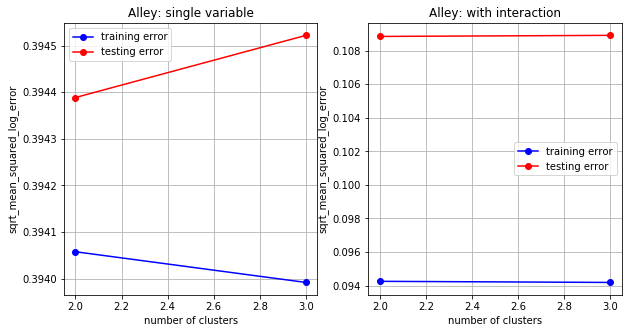

Iteration: 2 out of 3
Iteration: 3 out of 3


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


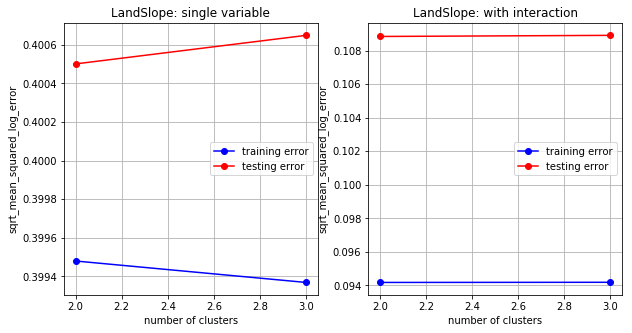

Iteration: 2 out of 3
Iteration: 3 out of 3


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


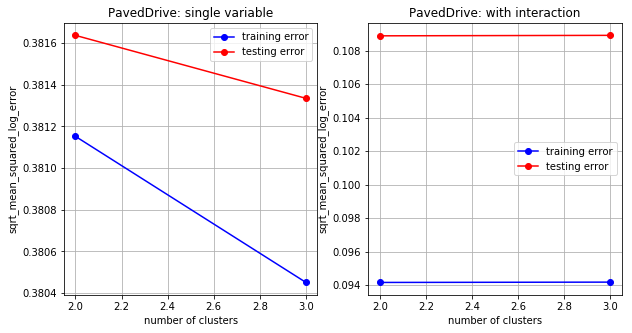

Iteration: 2 out of 2


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


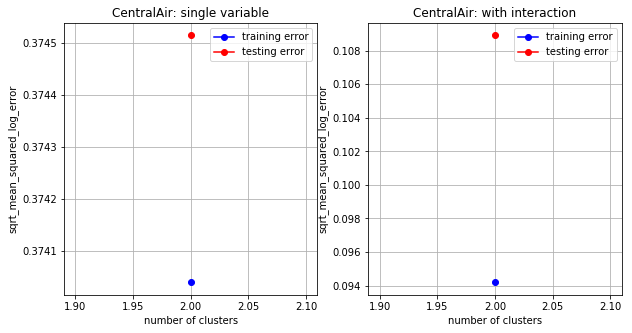

Iteration: 2 out of 2


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


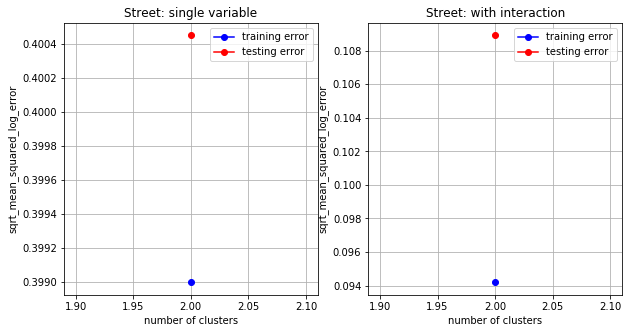

Iteration: 2 out of 2


C:\Users\tsyurmasto\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


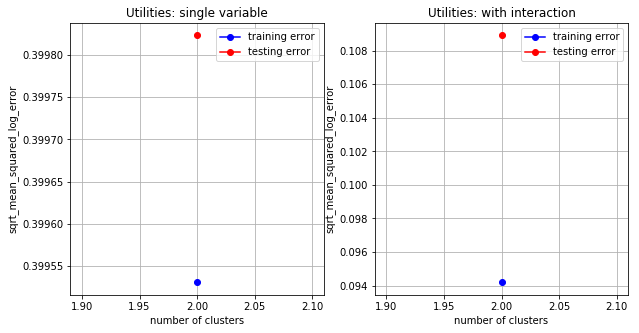

In [40]:
for col in cols_desc:
    find_n_clusters(data.drop(['SalePrice','Id'],axis=1),n_train,SalePrice,col[0],max_clusters=None)
    plt.show()

**optimal number of clusters**

In [8]:
optimal_n_clusters = {'Neighborhood':22,'Exterior2nd':2,'MSSubClass':2,'Exterior1st':8,'MoSold':2,'Condition1':2,
                     'SaleType':2,'Condition2':2,'HouseStyle':2,'BsmtFinType1':2,'BsmtFinType2':2,'Functional':4,
                     'GarageType':2,'RoofMatl':2,'FireplaceQu':2,'Foundation':2,'GarageCond':2,'GarageQual':2,
                      'Heating':4,'RoofStyle':2,'SaleCondition':3,'BldgType':2,'BsmtCond':2,'BsmtQual':3,
                      'Electrical':2,'ExterCond':2,'Fence':2,'HeatingQC':2,'LotConfig':2,'MSZoning':5,
                      'MiscFeature':2,'BsmtExposure':3,'ExterQual':2,'GarageFinish':2,'KitchenQual':3,
                      'LandContour':2,'LotShape':2,'MasVnrType':2,'PoolQC':2,'Alley':2,'LandSlope':2,'PavedDrive':2}

**perform clustering**

In [119]:
for key in optimal_n_clusters.keys():
    data32[key] = clusters(data,n_train,SalePrice,key,optimal_n_clusters[key],scatter_plot=False)
# fill single NA with mode
data32.fillna(data32['MSSubClass'].mode()[0],inplace=True)
data32.to_csv('dataset3.2.csv',index=False)
data32.head()

,SalePrice,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,...,EnclosedPorch_log,ScreenPorch_log,LotFrontage_log,12_rooms_plus_dummy,2_kitchens_plus_dummy,5_bedroom_plus_dummy,1_bedroom_less_dummy,4_garage_more_dummy,compPrice,compIndex
0,208500,856,854,0,3,706.0,0.0,1.0,0.0,150.0,...,0.000000,0.0,4.189655,0,0,0,0,0,202980.0,37.2
1,181500,1262,0,0,3,978.0,0.0,0.0,1.0,284.0,...,0.000000,0.0,4.394449,0,0,0,0,0,206791.8,32.4
2,223500,920,866,0,3,486.0,0.0,1.0,0.0,434.0,...,0.000000,0.0,4.234107,0,0,0,0,0,180480.0,37.2
3,140000,961,756,0,3,216.0,0.0,1.0,0.0,540.0,...,5.609472,0.0,4.110874,0,0,0,0,0,189220.0,31.0
4,250000,1145,1053,0,4,655.0,0.0,1.0,0.0,490.0,...,0.000000,0.0,4.442651,0,0,0,0,0,206150.0,36.4


**added to fix bug in dataset**

In [ ]:
df=pd.read_csv('dataset3.2.csv')
train=pd.read_csv('dataset2_addfeatures.csv')
df['SalePrice']=train['SalePrice']
df['Id']=train['Id']
df.to_csv('dataset3_2.csv',index=False)

**plot charts for selected categoric features**

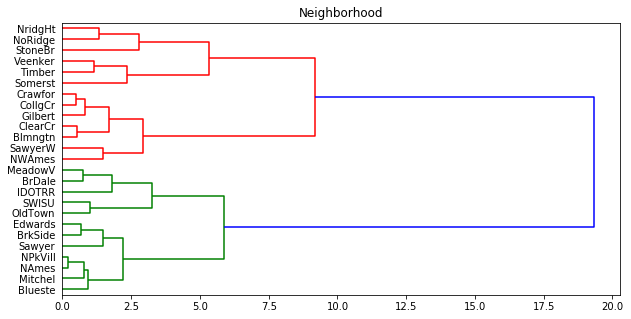

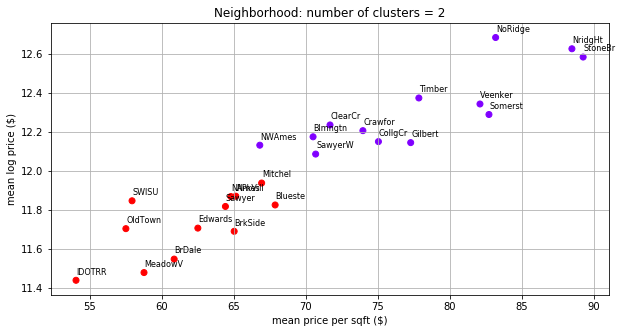

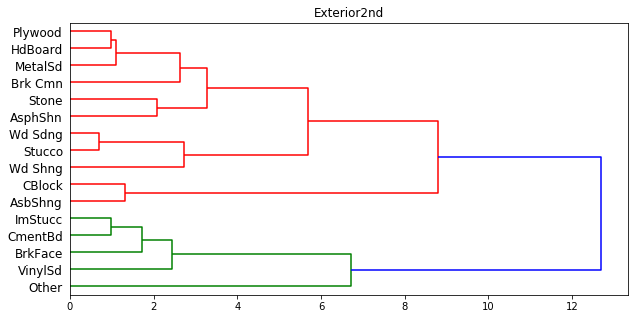

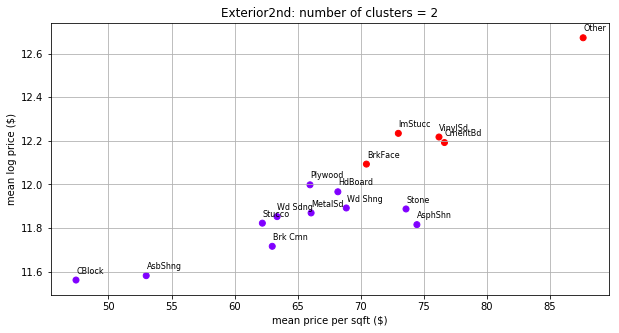

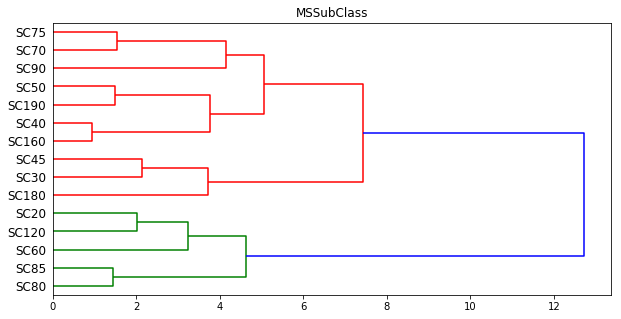

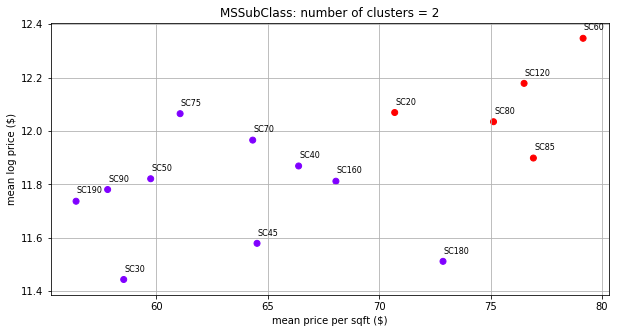

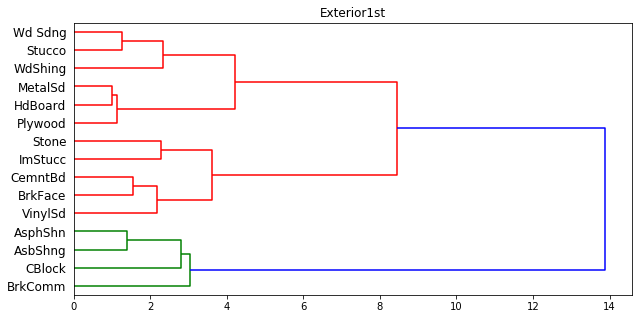

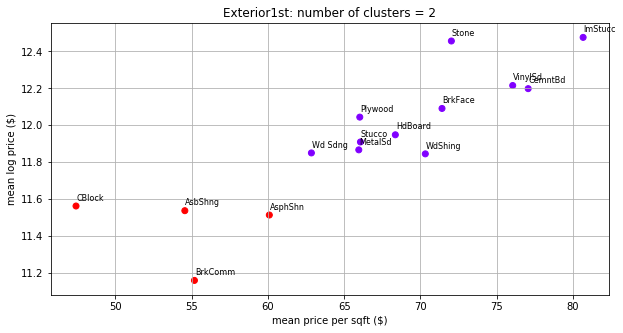

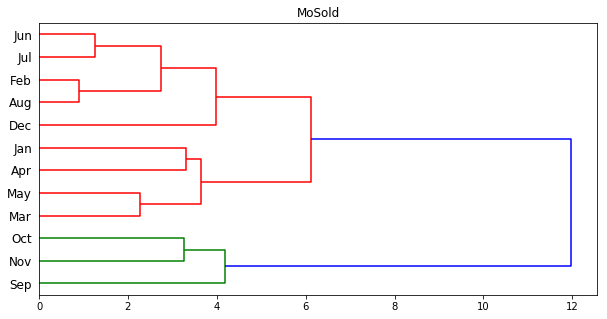

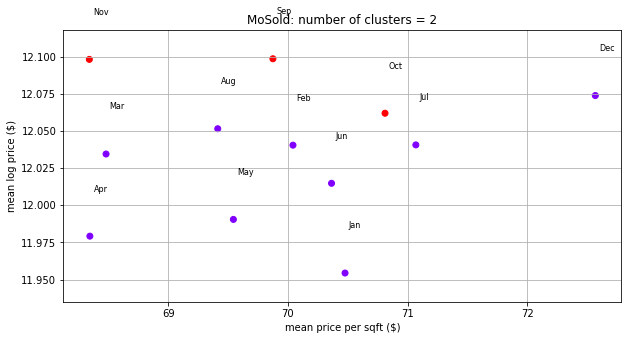

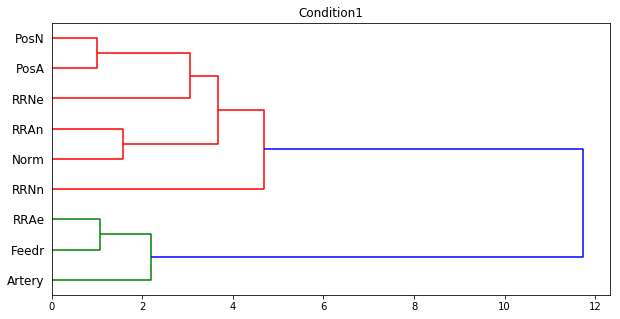

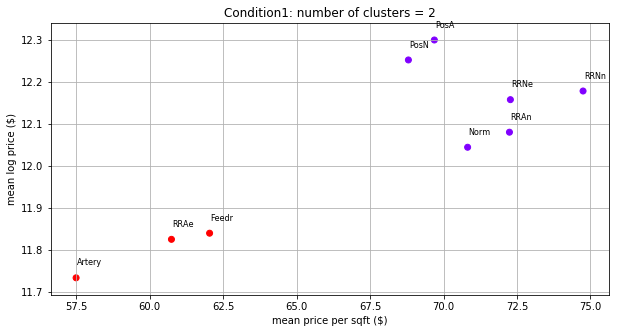

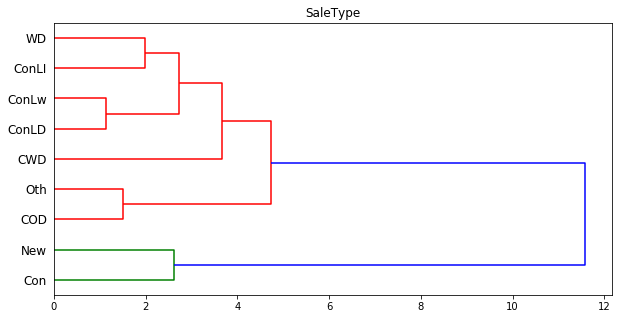

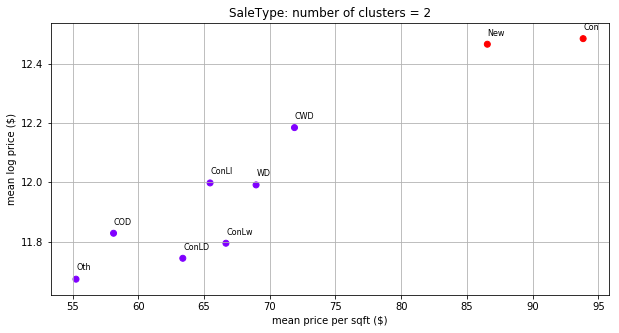

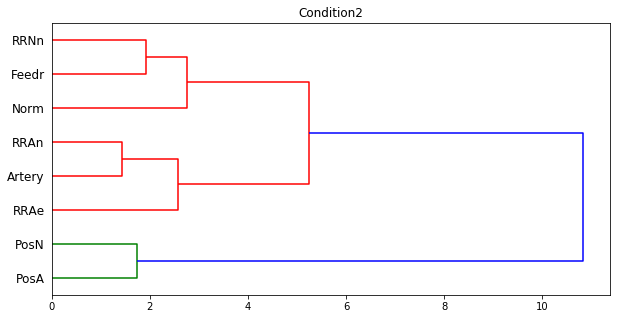

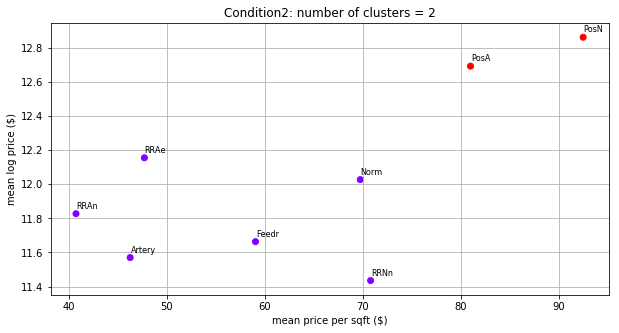

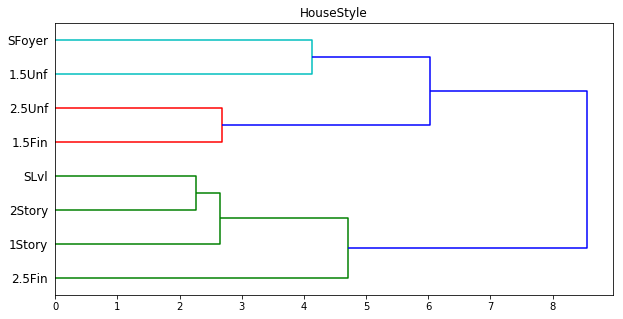

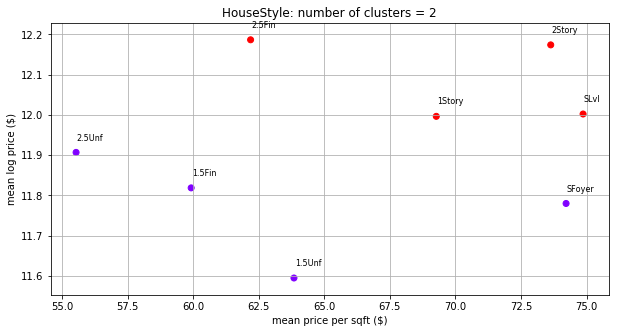

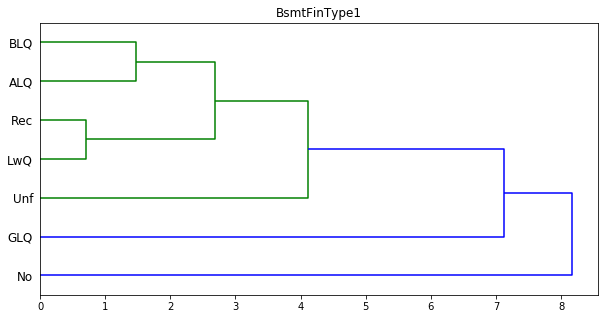

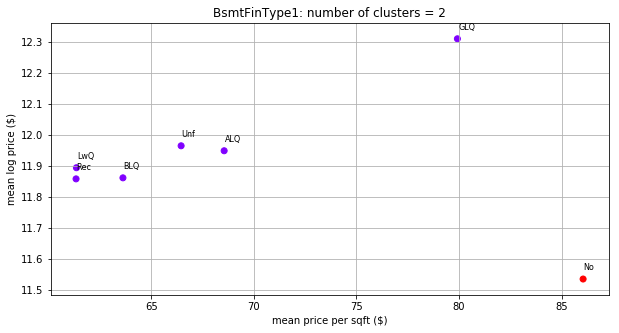

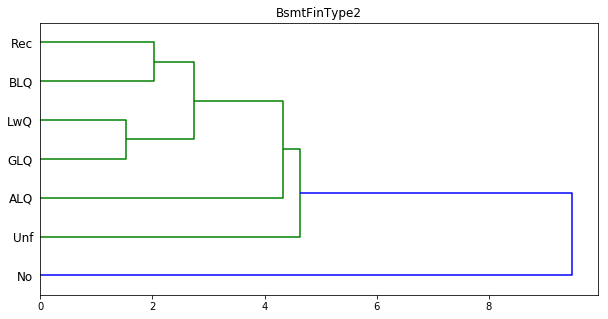

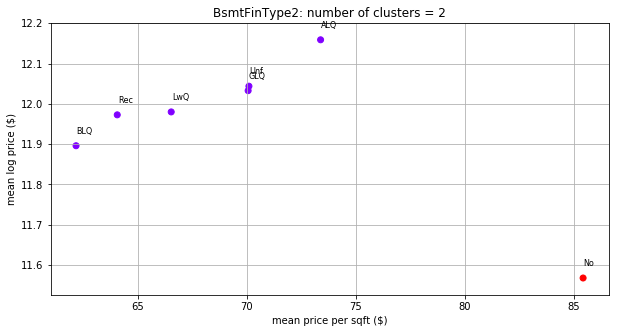

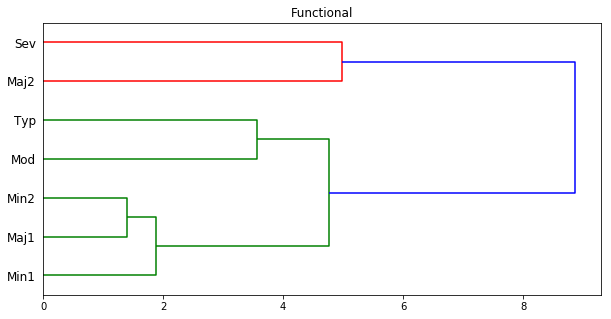

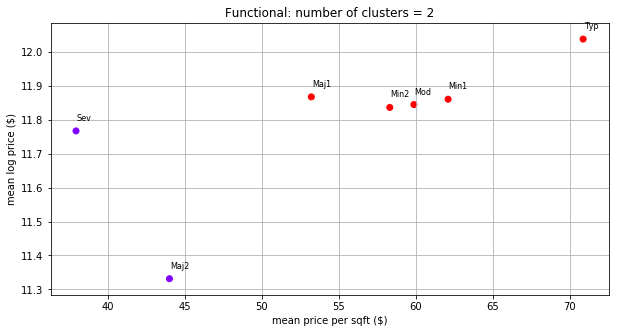

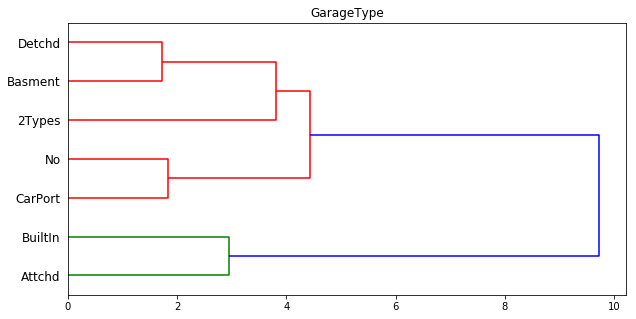

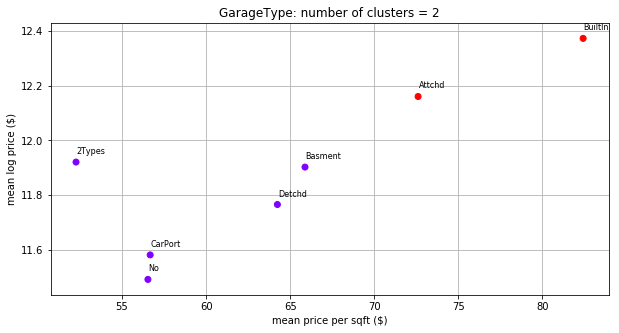

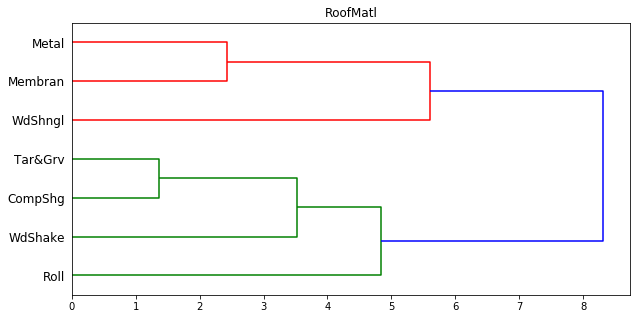

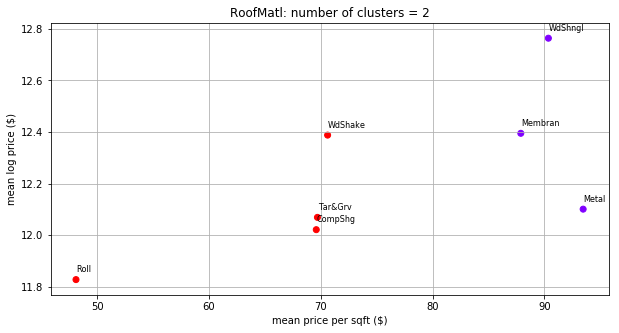

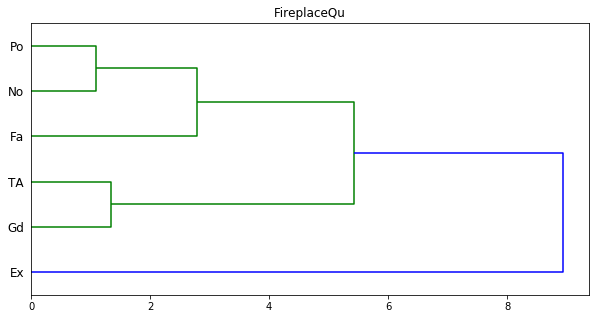

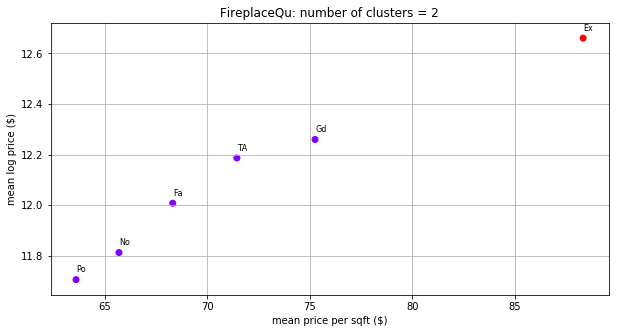

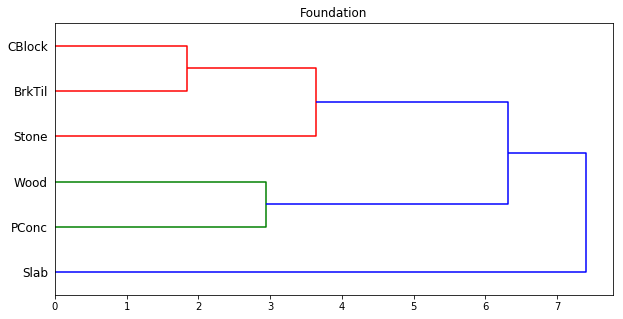

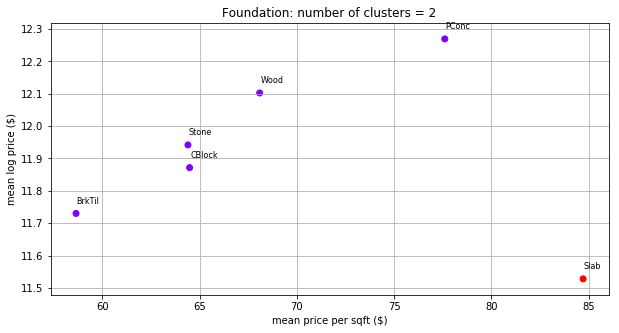

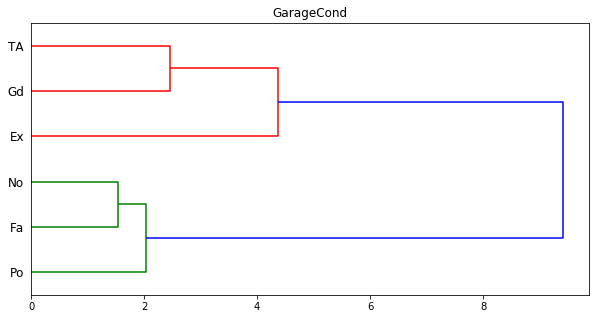

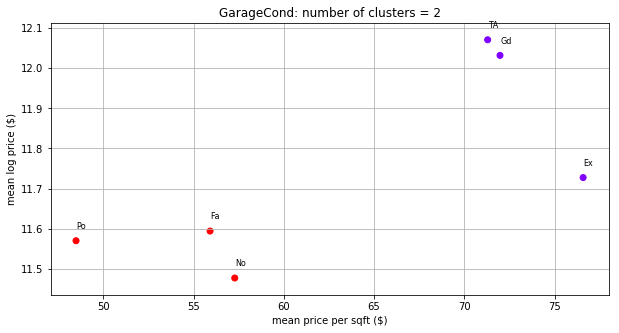

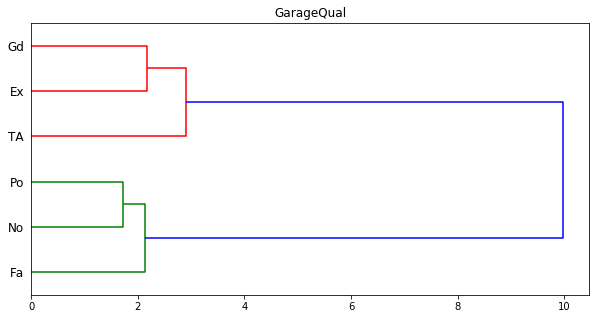

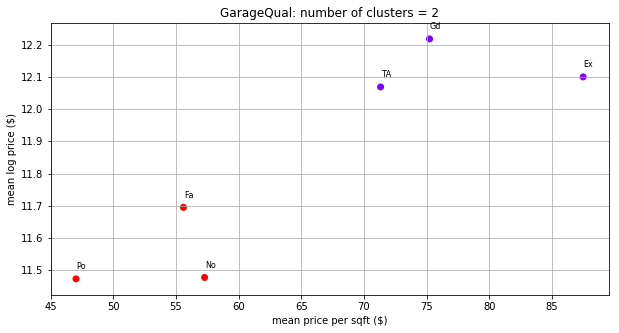

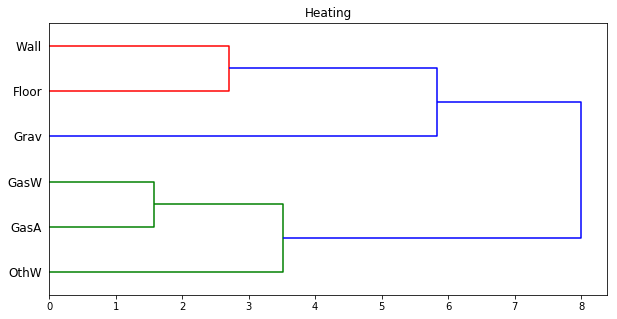

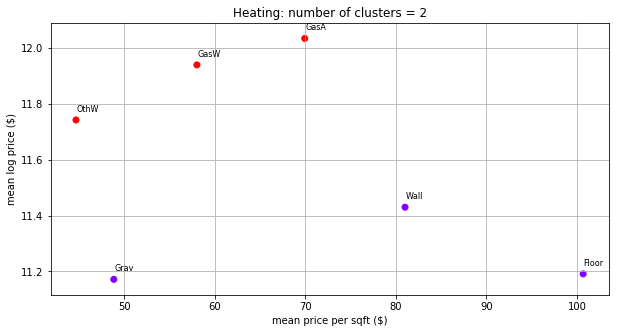

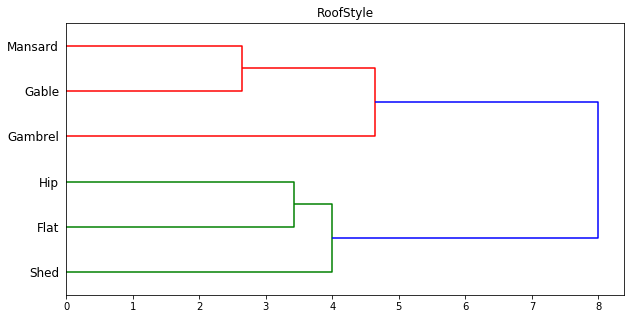

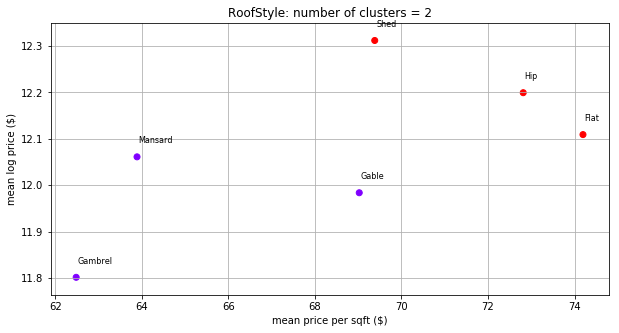

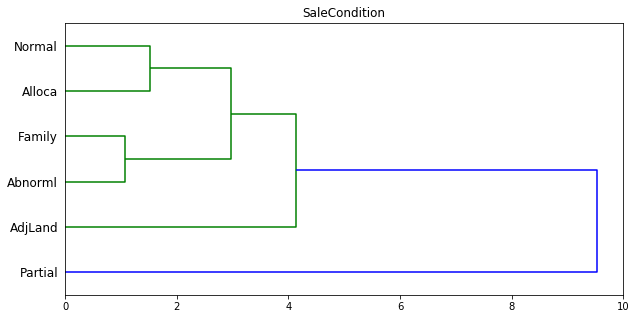

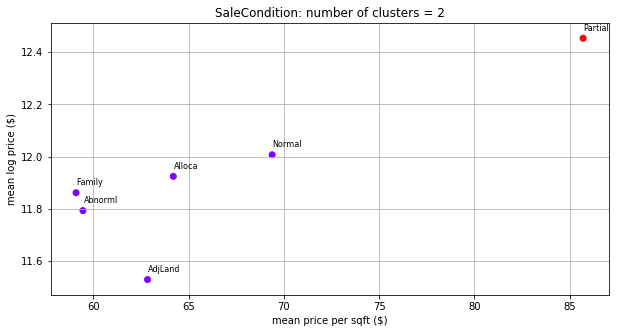

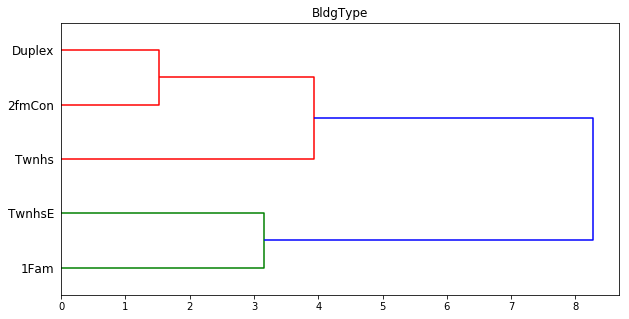

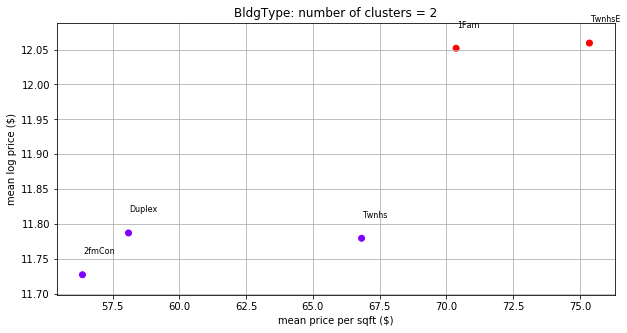

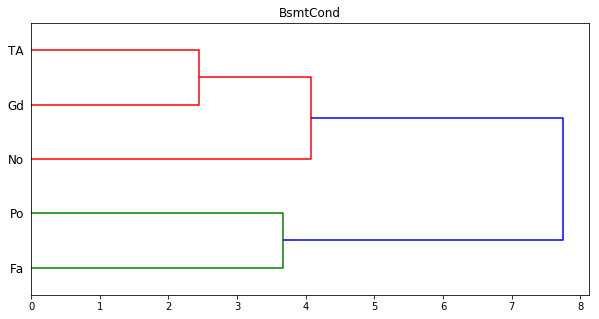

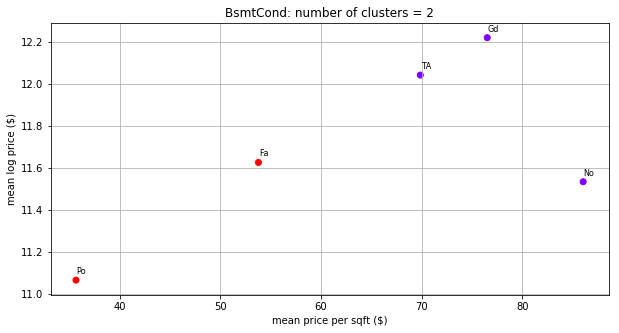

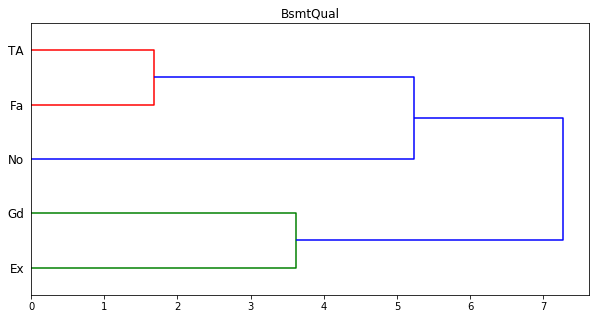

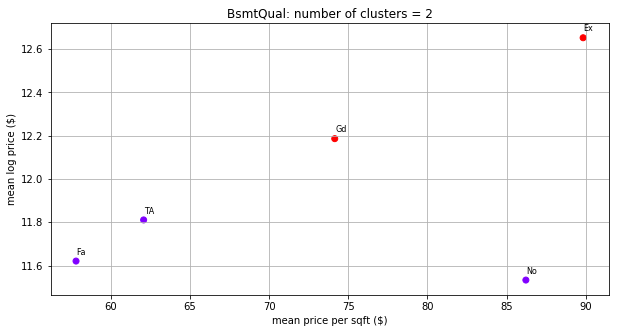

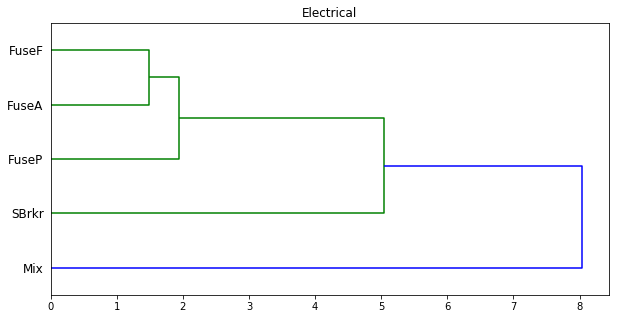

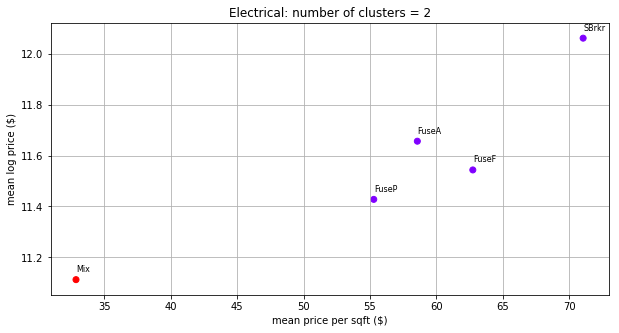

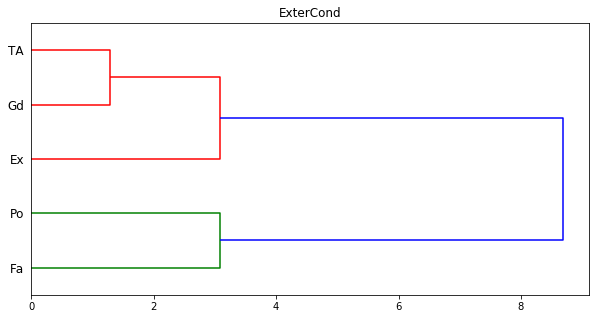

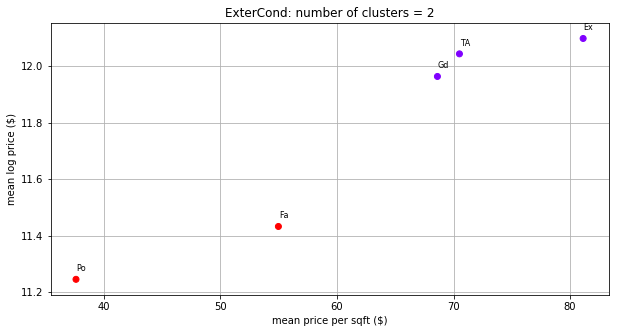

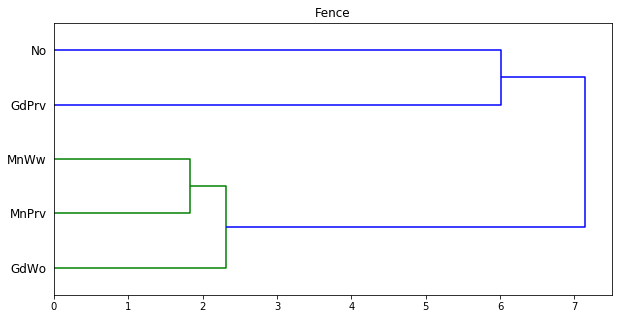

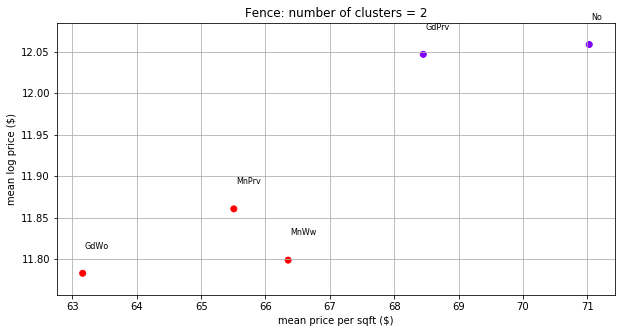

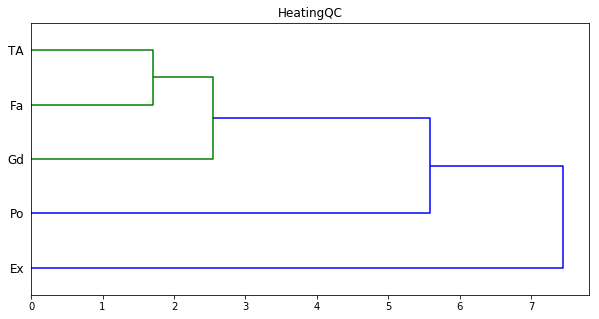

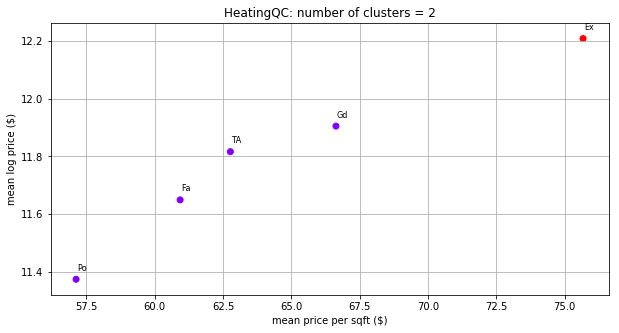

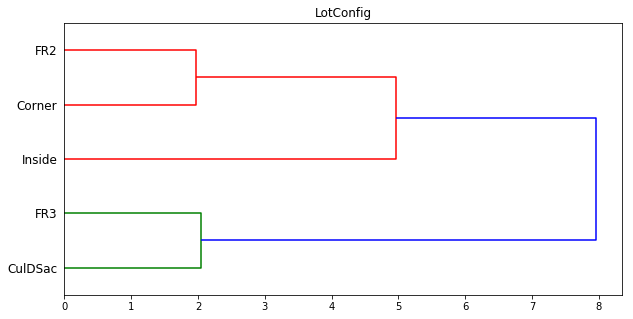

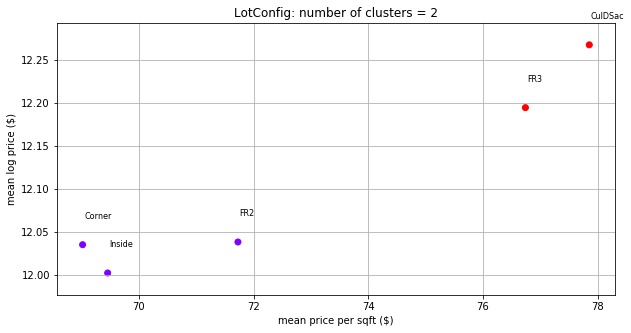

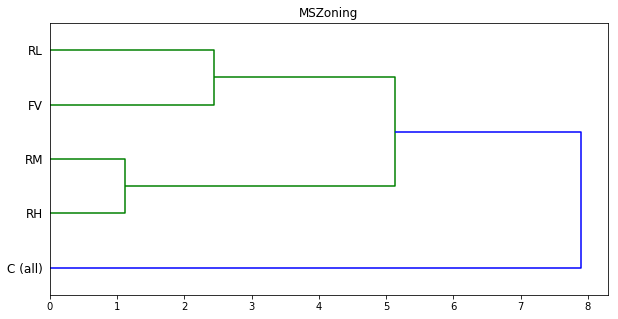

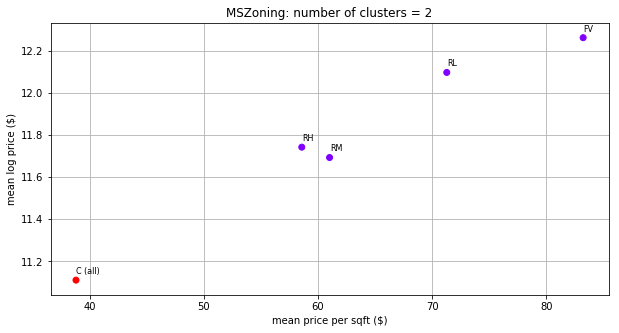

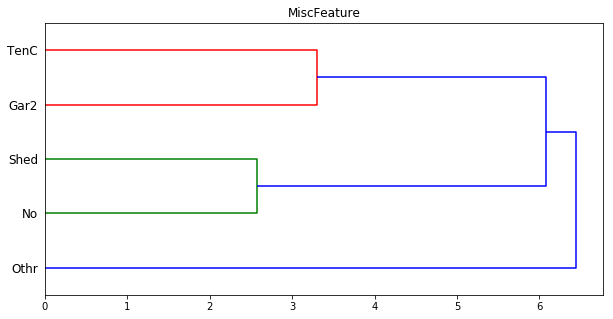

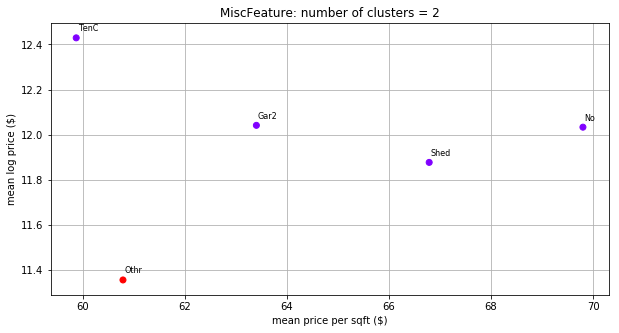

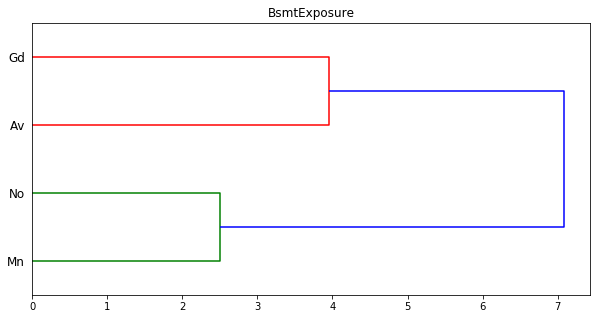

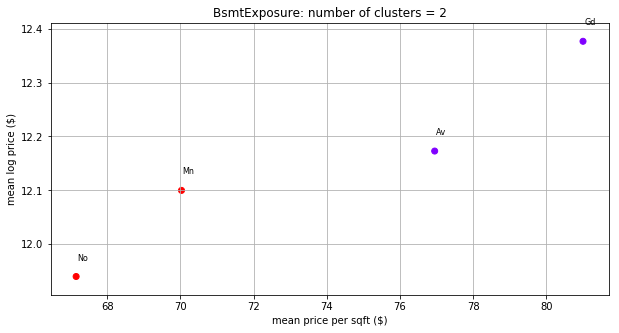

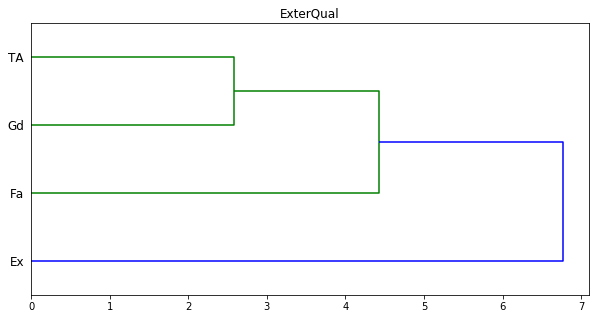

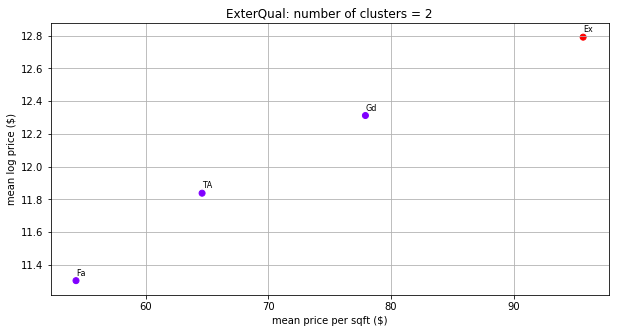

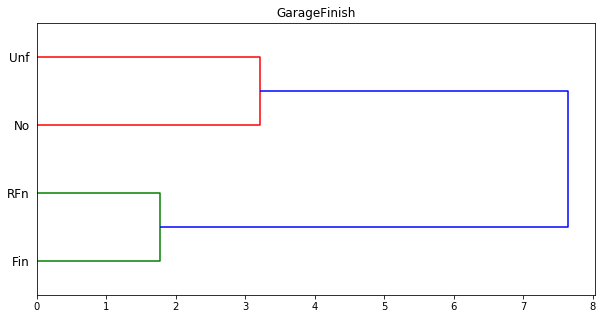

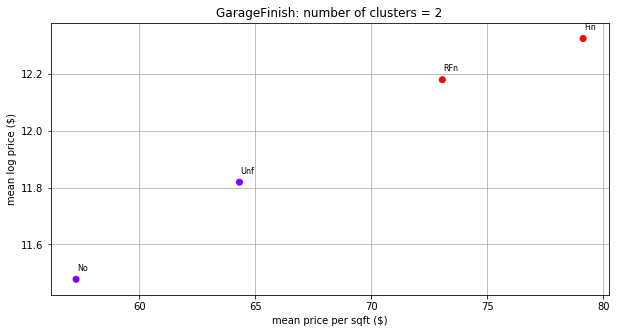

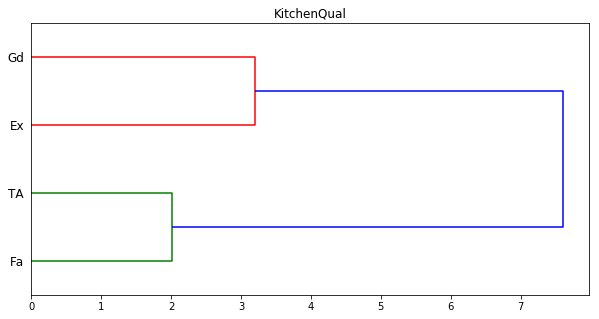

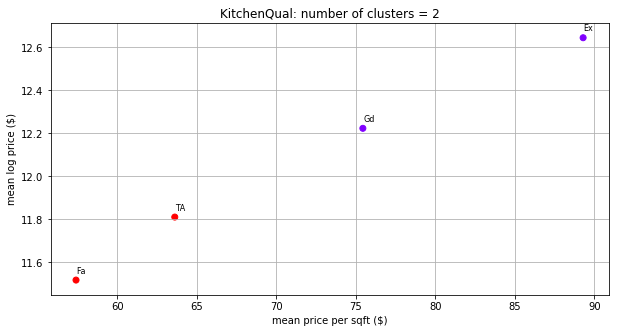

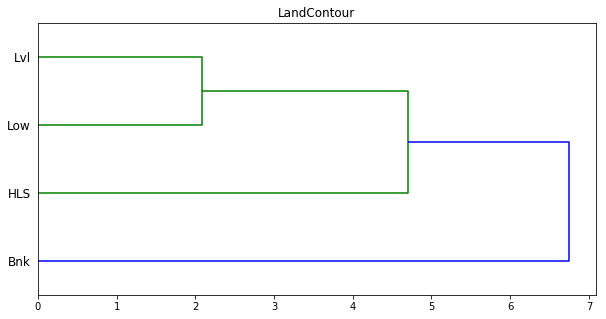

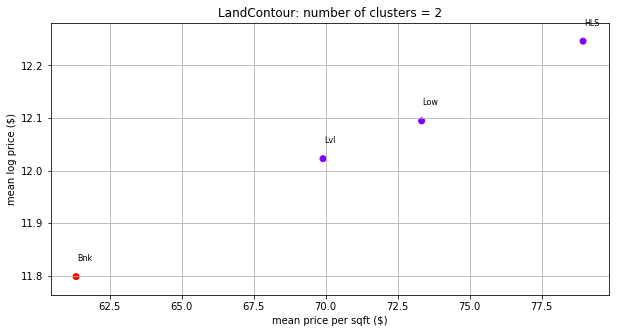

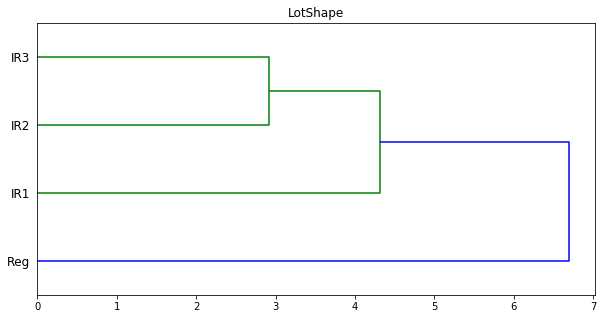

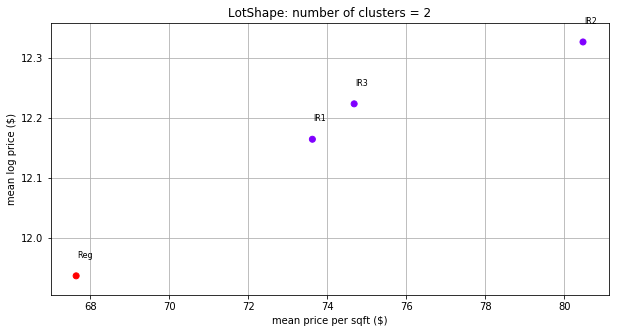

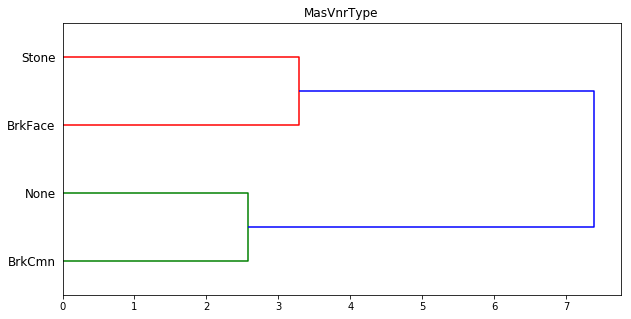

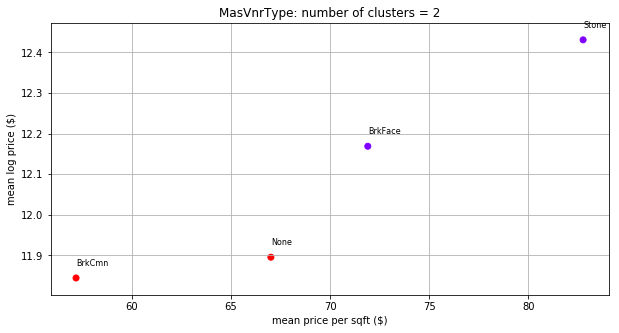

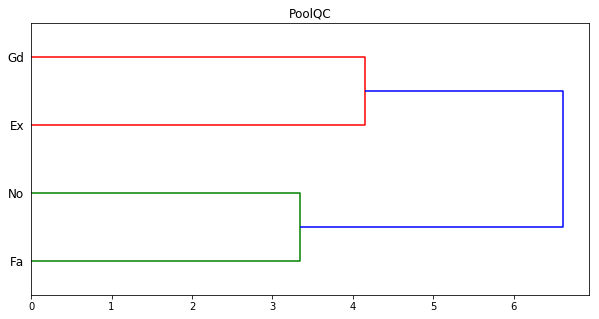

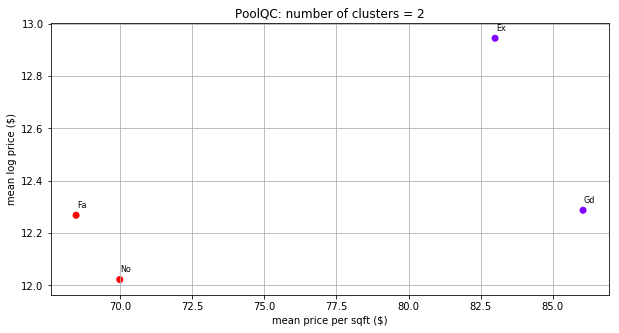

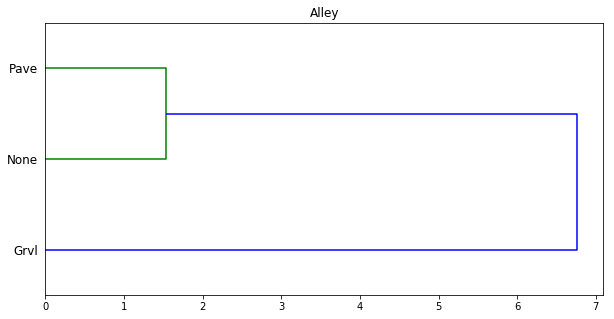

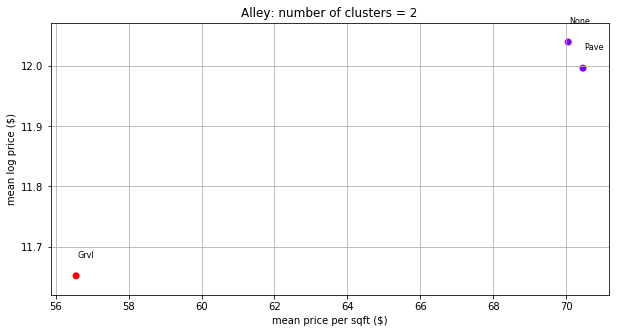

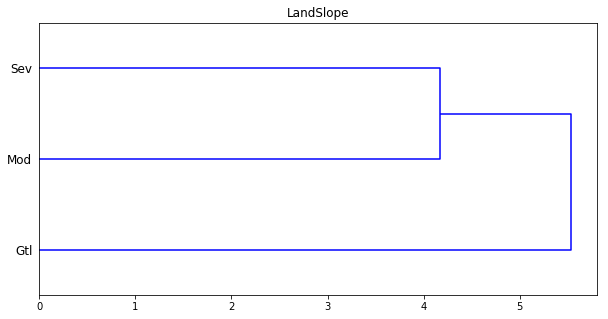

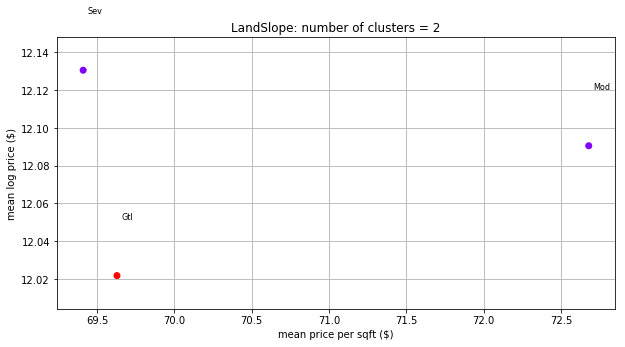

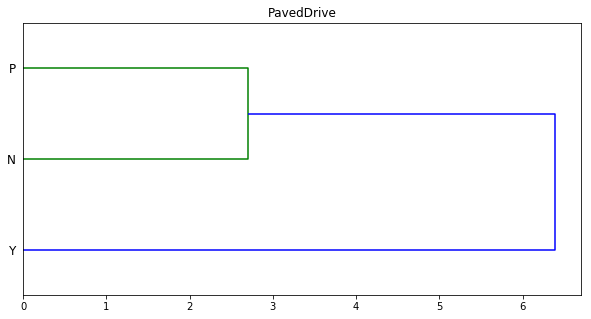

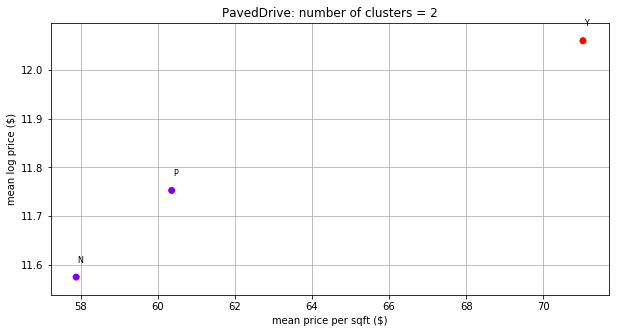

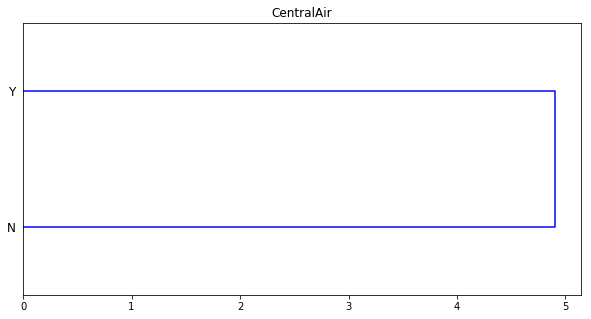

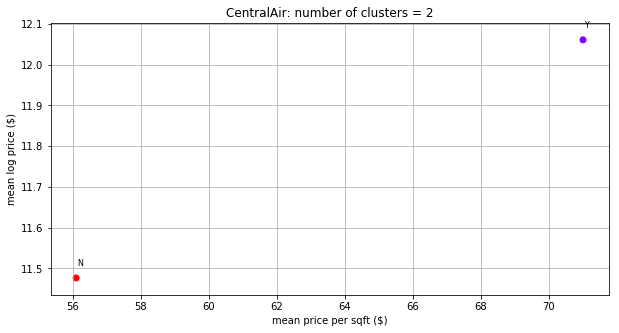

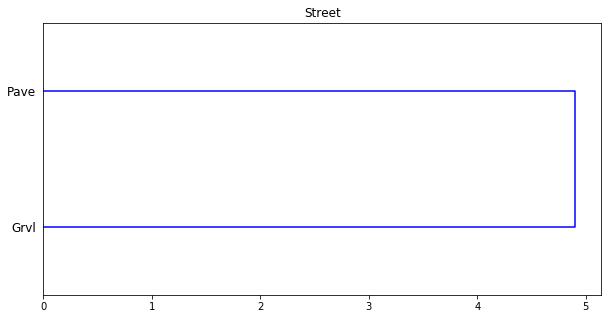

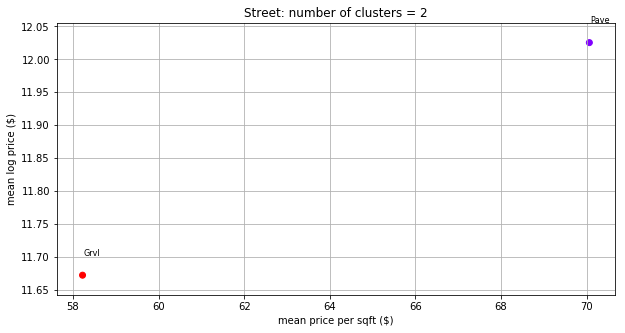

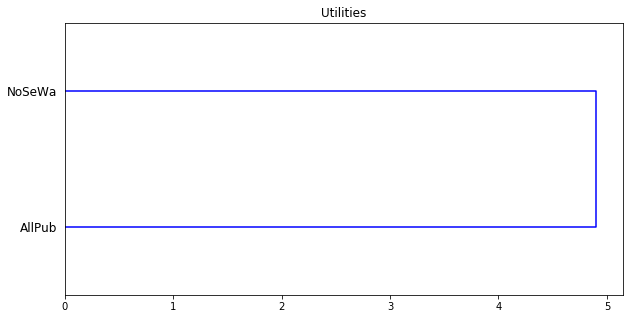

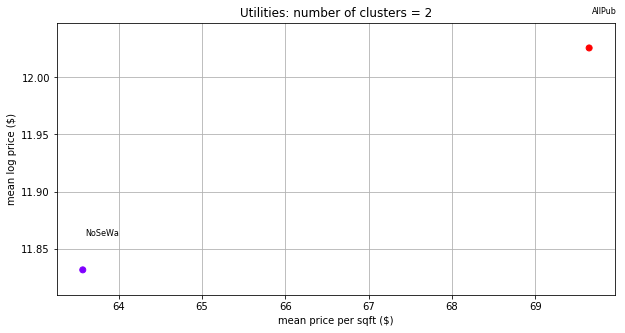

In [118]:
for item in cols_desc:
    col = item[0]
    # prepare clustering data
    df = prepare_clustering_data(data,n_train,SalePrice,col)
    # show dendrogram
    plot_dendrogram(df,col)
    # perform clustering
    temp = clusters(data,n_train,SalePrice,col,2,scatter_plot=True)

**check number of features (dummified) before and after merging: number of features reduces from 363 to 198!**

In [120]:
pd.concat([data.loc[:,cols_numeric],pd.get_dummies(data.loc[:,cols_categoric])]).head()

,12_rooms_plus_dummy,1_bedroom_less_dummy,1stFlrSF,1stFlrSF_log,2_kitchens_plus_dummy,2ndFlrSF,2ndFlrSF_log,3SsnPorch,3SsnPorch_log,4_garage_more_dummy,...,Utilities_NoSeWa,WoodDeckSF,WoodDeckSF_log,YearBuilt,YearBuiltAge,YearRemodAdd,YearRemodAddAge,YrSold,compIndex,compPrice
0,0.0,0.0,856.0,6.753438,0.0,854.0,6.751101,0.0,0.0,0.0,...,NaN,0.0,0.000000,2003.0,5.0,2003.0,5.0,2008.0,37.2,202980.0
1,0.0,0.0,1262.0,7.141245,0.0,0.0,0.000000,0.0,0.0,0.0,...,NaN,298.0,5.700444,1976.0,31.0,1976.0,31.0,2007.0,32.4,206791.8
2,0.0,0.0,920.0,6.825460,0.0,866.0,6.765039,0.0,0.0,0.0,...,NaN,0.0,0.000000,2001.0,7.0,2002.0,6.0,2008.0,37.2,180480.0
3,0.0,0.0,961.0,6.869014,0.0,756.0,6.629363,0.0,0.0,0.0,...,NaN,0.0,0.000000,1915.0,91.0,1970.0,36.0,2006.0,31.0,189220.0
4,0.0,0.0,1145.0,7.044033,0.0,1053.0,6.960348,0.0,0.0,0.0,...,NaN,192.0,5.262690,2000.0,8.0,2000.0,8.0,2008.0,36.4,206150.0


In [121]:
pd.concat([data32.loc[:,cols_numeric],pd.get_dummies(data32.loc[:,cols_categoric])]).head()

,12_rooms_plus_dummy,1_bedroom_less_dummy,1stFlrSF,1stFlrSF_log,2_kitchens_plus_dummy,2ndFlrSF,2ndFlrSF_log,3SsnPorch,3SsnPorch_log,4_garage_more_dummy,...,Utilities_NoSeWa,WoodDeckSF,WoodDeckSF_log,YearBuilt,YearBuiltAge,YearRemodAdd,YearRemodAddAge,YrSold,compIndex,compPrice
0,0.0,0.0,856.0,6.753438,0.0,854.0,6.751101,0.0,0.0,0.0,...,NaN,0.0,0.000000,2003.0,5.0,2003.0,5.0,2008.0,37.2,202980.0
1,0.0,0.0,1262.0,7.141245,0.0,0.0,0.000000,0.0,0.0,0.0,...,NaN,298.0,5.700444,1976.0,31.0,1976.0,31.0,2007.0,32.4,206791.8
2,0.0,0.0,920.0,6.825460,0.0,866.0,6.765039,0.0,0.0,0.0,...,NaN,0.0,0.000000,2001.0,7.0,2002.0,6.0,2008.0,37.2,180480.0
3,0.0,0.0,961.0,6.869014,0.0,756.0,6.629363,0.0,0.0,0.0,...,NaN,0.0,0.000000,1915.0,91.0,1970.0,36.0,2006.0,31.0,189220.0
4,0.0,0.0,1145.0,7.044033,0.0,1053.0,6.960348,0.0,0.0,0.0,...,NaN,192.0,5.262690,2000.0,8.0,2000.0,8.0,2008.0,36.4,206150.0
